# Building a Retrieval-Augmented Generation (RAG) System

This notebook implements a Retrieval-Augmented Generation (RAG) system using:
- LangChain for document processing and vector operations
- FAISS for efficient similarity search
- Ollama for local LLM inference
- HuggingFace embeddings for text vectorization

We'll build a system that can answer questions about PDF documents by:
1. Loading and processing PDFs
2. Creating vector embeddings from the text
3. Performing similarity search for relevant content
4. Generating contextual answers using a local LLM

## 1. Setup Environment and Import Libraries

First, we need to install the required packages:

In [1]:
# # Install required packages
# %pip install langchain faiss-cpu pypdf2 ollama sentence-transformers

In [2]:
# %pip install -U langchain-community

In [3]:
# %pip install ipywidgets matplotlib

Now, let's import all the necessary libraries:

In [4]:
# Import necessary libraries
import os
import ollama
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from IPython.display import Markdown, display
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import time

## 2. PDF Loading and Text Extraction

We'll create a function to load PDF files and extract text from them:

In [5]:
def load_pdf(file_path):
    """
    Load a PDF file and extract text from it.
    
    Args:
        file_path (str): Path to the PDF file
        
    Returns:
        str: Extracted text from the PDF
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    with open(file_path, "rb") as file:
        reader = PdfReader(file)
        text = ""
        num_pages = len(reader.pages)
        
        print(f"Processing {num_pages} pages...")
        
        for i, page in enumerate(reader.pages):
            page_text = page.extract_text()
            text += page_text + "\n"
            # Print progress
            if (i+1) % 5 == 0 or i+1 == num_pages:
                print(f"Processed {i+1}/{num_pages} pages")
                
    print(f"Extracted {len(text)} characters of text.")
    return text

In [6]:
# Add after the load_pdf function

def load_pdfs_from_directory(directory_path):
    """
    Load all PDF files from a directory.
    
    Args:
        directory_path (str): Path to the directory containing PDFs
        
    Returns:
        list: List of tuples (filename, text_content)
    """
    import glob
    
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"The directory {directory_path} does not exist.")
    
    pdf_files = glob.glob(os.path.join(directory_path, "*.pdf"))
    
    if not pdf_files:
        print(f"No PDF files found in {directory_path}")
        return []
    
    print(f"Found {len(pdf_files)} PDF files in {directory_path}")
    
    all_documents = []
    
    for pdf_file in pdf_files:
        try:
            print(f"\nProcessing: {os.path.basename(pdf_file)}")
            pdf_text = load_pdf(pdf_file)
            all_documents.append((os.path.basename(pdf_file), pdf_text))
            print(f"Successfully loaded {os.path.basename(pdf_file)}")
        except Exception as e:
            print(f"Error loading {pdf_file}: {str(e)}")
    
    return all_documents

Let's test our PDF loading function with a sample PDF. For this example, we'll use the annual report PDF mentioned in the original code:

In [7]:
# Replace the PDF loading cell with this

# Path to the directory containing PDFs
reports_directory = "../Reports"

try:
    # Load all PDFs from the directory
    documents = load_pdfs_from_directory(reports_directory)
    
    if documents:
        print(f"\nSuccessfully loaded {len(documents)} documents")
        
        # Display summary of loaded documents
        total_text_length = sum(len(text) for _, text in documents)
        print(f"Total text length across all documents: {total_text_length} characters")
        
        for filename, text in documents[:3]:  # Show details for first 3 documents
            print(f"\n{filename}: {len(text)} characters")
            print("Sample text (first 200 characters):")
            print("-" * 50)
            print(text[:200] + "...")
            print("-" * 50)
            
        if len(documents) > 3:
            print(f"... and {len(documents) - 3} more document(s)")
    else:
        print("No documents were loaded. Using sample text for demonstration.")
        # Create a placeholder for demonstration purposes
        documents = [("sample.pdf", "This is a sample text that simulates content from a PDF file. " * 100)]
        
except Exception as e:
    print(f"Error: {str(e)}")
    # Create a placeholder for demonstration purposes
    documents = [("sample.pdf", "This is a sample text that simulates content from a PDF file. " * 100)]

Found 5 PDF files in ../Reports

Processing: infosys-ar-20.pdf
Processing 313 pages...
Processed 5/313 pages
Processed 10/313 pages
Processed 15/313 pages
Processed 20/313 pages
Processed 25/313 pages
Processed 30/313 pages
Processed 35/313 pages
Processed 40/313 pages
Processed 45/313 pages
Processed 50/313 pages
Processed 55/313 pages
Processed 60/313 pages
Processed 65/313 pages
Processed 70/313 pages
Processed 75/313 pages
Processed 80/313 pages
Processed 85/313 pages
Processed 90/313 pages
Processed 95/313 pages
Processed 100/313 pages
Processed 105/313 pages
Processed 110/313 pages
Processed 115/313 pages
Processed 120/313 pages
Processed 125/313 pages
Processed 130/313 pages
Processed 135/313 pages
Processed 140/313 pages
Processed 145/313 pages
Processed 150/313 pages
Processed 155/313 pages
Processed 160/313 pages
Processed 165/313 pages
Processed 170/313 pages
Processed 175/313 pages
Processed 180/313 pages
Processed 185/313 pages
Processed 190/313 pages
Processed 195/313 pag

## 3. Text Chunking and Vector Store Creation

For effective retrieval, we need to split the text into manageable chunks and create embeddings:

In [8]:
# Replace the create_vector_store function with this version

def create_vector_store(documents, chunk_size=1000, chunk_overlap=200):
    """
    Split text into chunks and create a vector store with metadata.
    
    Args:
        documents (list): List of (filename, text) tuples
        chunk_size (int): Size of each chunk
        chunk_overlap (int): Overlap between chunks
        
    Returns:
        FAISS: Vector store object
    """
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    
    start_time = time.time()
    all_chunks = []
    all_metadatas = []
    
    for filename, text in documents:
        chunks = text_splitter.split_text(text)
        metadatas = [{"source": filename} for _ in range(len(chunks))]
        
        all_chunks.extend(chunks)
        all_metadatas.extend(metadatas)
    
    chunking_time = time.time() - start_time
    
    print(f"Split text into {len(all_chunks)} chunks across {len(documents)} documents (took {chunking_time:.2f} seconds)")
    
    # Create embeddings
    print("Initializing embedding model...")
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    
    # Create vector store
    print("Creating vector store...")
    start_time = time.time()
    vector_store = FAISS.from_texts(all_chunks, embeddings, metadatas=all_metadatas)
    vectorization_time = time.time() - start_time
    
    print(f"Vector store created with {len(all_chunks)} vectors (took {vectorization_time:.2f} seconds)")
    
    return vector_store, all_chunks

Split text into 7545 chunks across 5 documents (took 0.12 seconds)
Initializing embedding model...


/tmp/ipykernel_2370113/475983215.py:39: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Creating vector store...
Vector store created with 7545 vectors (took 7.08 seconds)


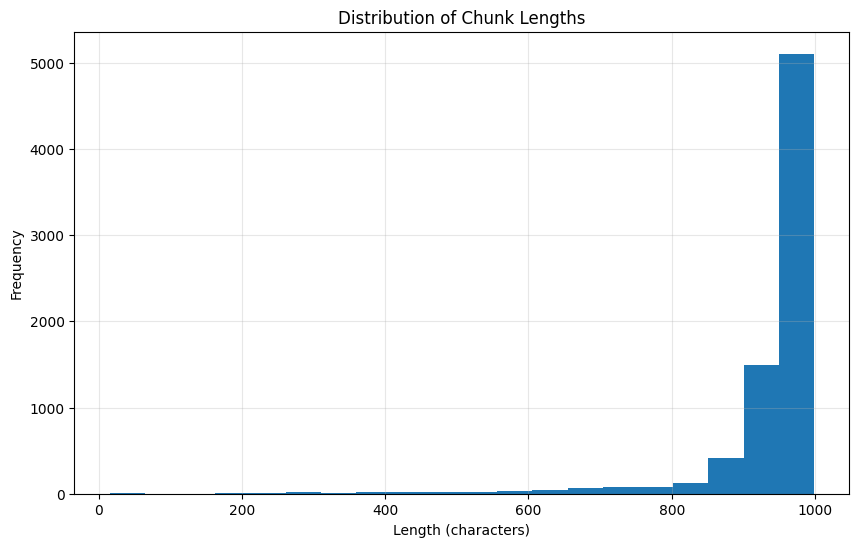

Average chunk length: 939.4 characters
Shortest chunk: 15 characters
Longest chunk: 999 characters


In [9]:
# Replace the vector store creation cell with this

# Create vector store from all documents
vector_store, chunks = create_vector_store(documents)

# Display some statistics about the chunks
chunk_lengths = [len(chunk) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=20)
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average chunk length: {np.mean(chunk_lengths):.1f} characters")
print(f"Shortest chunk: {min(chunk_lengths)} characters")
print(f"Longest chunk: {max(chunk_lengths)} characters")

Let's examine a few chunks to understand what our text looks like after chunking:

In [10]:
# with open("chunk_preview.txt", "w", encoding="utf-8") as f:
#     for chunk in chunks[:3]:
#         f.write(chunk[:100] + "...\n\n")


In [11]:
# # Display a few example chunks
# for i in range(min(3, len(chunks))):
#     print(f"Chunk {i+1} ({len(chunks[i])} characters):")
#     print("-" * 50)
#     print(chunks[i][:300] + "...")  # Show first 300 chars
#     print("-" * 50)

## 4. Question Answering with Ollama

Now, let's implement the question answering functionality using the Ollama API with the deepseek-r1 model:

In [12]:
def ask_ollama(query, context):
    """
    Generate an answer using Ollama API based on the provided context.
    
    Args:
        query (str): The user's question
        context (str): Context information retrieved from the vector store
        
    Returns:
        str: Generated answer from the model
    """
    prompt = f"""
    Answer the question based on the following context:

    Context:
    {context}

    Question: {query}
    
    Answer:
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        
        return response['message']['content']
    except Exception as e:
        return f"Error generating response: {str(e)}"

In [13]:
# Update the answer_question function to show source information

def answer_question(query, vector_store, k=4):
    """
    Answer a question using RAG approach.
    
    Args:
        query (str): User's question
        vector_store: FAISS vector store
        k (int): Number of relevant chunks to retrieve
        
    Returns:
        str: Answer to the question
    """
    print(f"Searching for context relevant to: '{query}'")
    
    # Retrieve relevant chunks
    start_time = time.time()
    docs = vector_store.similarity_search(query, k=k)
    search_time = time.time() - start_time
    
    print(f"Retrieved {len(docs)} relevant chunks (took {search_time:.2f} seconds)")
    
    # Format context with source information
    context_parts = []
    for doc in docs:
        source = doc.metadata.get('source', 'Unknown')
        context_parts.append(f"Source: {source}\n{doc.page_content}")
    
    context = "\n\n---\n\n".join(context_parts)
    context_length = len(context)
    
    print(f"Sending prompt with context of {context_length} characters to Ollama...")
    
    # Get answer from Ollama
    start_time = time.time()
    answer = ask_ollama(query, context)
    generation_time = time.time() - start_time
    
    print(f"Generated answer of {len(answer)} characters (took {generation_time:.2f} seconds)")
    
    return answer, docs

Let's test our question answering function with a sample question:

In [14]:
# Test with a sample question
sample_question = "What are the main financial highlights?"
answer, relevant_docs = answer_question(sample_question, vector_store)

print("\nQuestion:", sample_question)
print("\nAnswer:")
print("-" * 80)
print(answer)
print("-" * 80)

print("\nTop relevant context used:")
for i, doc in enumerate(relevant_docs[:2]):  # Show only first 2 contexts
    print(f"\nContext chunk {i+1}:")
    print("..." + doc.page_content[:300] + "...")  # First 300 chars

Searching for context relevant to: 'What are the main financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4033 characters to Ollama...


Generated answer of 3235 characters (took 9.45 seconds)

Question: What are the main financial highlights?

Answer:
--------------------------------------------------------------------------------
<think>
Alright, I need to figure out the main financial highlights from the given context. Let me start by reading through each source carefully.

First, looking at infosys-ar-23.pdf, there's a section about consolidated cash and investments that includes various financial instruments like deposits in banks, mutual funds, fixed maturity securities, etc. Then, there are details on their investments in startups, mentioning minority equity positions and venture capital funds. The investment values are provided for different years.

Next, infosys-ar-24.pdf talks about performance highlights, including a Return on Equity (ROE) of 32.1% with an AAA rating from CRISIL, a Dividend per share growth of 50,638 cr and ROE, EPS growth at 35.3%, and other figures like dividend per share growth.

Looking f

## 5. Interactive Demo

Let's create an interactive demo using IPython widgets:

In [15]:
def create_interactive_demo(vector_store):
    """Create an interactive demo for question answering"""
    
    # Create widgets
    question_input = widgets.Text(
        value='',
        description='Question:',
        placeholder='Type your question here...',
        layout=widgets.Layout(width='80%')
    )
    
    k_slider = widgets.IntSlider(
        value=4,
        min=1,
        max=10,
        step=1,
        description='Context chunks:',
        layout=widgets.Layout(width='50%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Get Answer',
        button_style='primary',
        tooltip='Click to get the answer',
        icon='search'
    )
    
    def on_button_clicked(_):
        with output:
            output.clear_output()
            if question_input.value.strip():
                print(f"Question: {question_input.value}")
                print("Generating answer...")
                answer, docs = answer_question(question_input.value, vector_store, k=k_slider.value)
                display(Markdown("### Answer:"))
                display(Markdown(answer))
                
                display(Markdown("### Sources:"))
                for i, doc in enumerate(docs):
                    display(Markdown(f"**Source {i+1}** (extract):\n> {doc.page_content[:150]}..."))
            else:
                print("Please enter a question.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>RAG Question Answering System</h3>"),
        widgets.HBox([question_input, button]),
        k_slider,
        output
    ])

In [16]:
# Create and display the interactive demo
demo = create_interactive_demo(vector_store)
display(demo)

## 6. Error Handling and Improvements

Let's enhance our system with better error handling and explore potential improvements:

In [17]:
class RAGSystem:
    """A more robust implementation of our RAG system with error handling"""
    
    def __init__(self, model_name="deepseek-r1", 
                 embeddings_model="sentence-transformers/all-MiniLM-L6-v2",
                 chunk_size=1000, chunk_overlap=200):
        self.model_name = model_name
        self.embeddings_model_name = embeddings_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.vector_store = None
        self.chunks = []
        self.pdf_text = ""
        
    def load_document(self, file_path):
        """Load document and handle errors"""
        try:
            if file_path.lower().endswith('.pdf'):
                self.pdf_text = load_pdf(file_path)
                return True, f"Successfully loaded PDF with {len(self.pdf_text)} characters"
            else:
                return False, "Only PDF files are currently supported"
        except FileNotFoundError:
            return False, f"File not found: {file_path}"
        except Exception as e:
            return False, f"Error loading document: {str(e)}"
    
    def process_document(self):
        """Process the loaded document and create vector store"""
        try:
            if not self.pdf_text:
                return False, "No document loaded. Please load a document first."
            
            self.vector_store, self.chunks = create_vector_store(
                self.pdf_text, self.chunk_size, self.chunk_overlap
            )
            return True, f"Successfully processed document into {len(self.chunks)} chunks"
        except Exception as e:
            return False, f"Error processing document: {str(e)}"
    
    def answer_query(self, query, k=4):
        """Answer a query with improved error handling"""
        try:
            if not self.vector_store:
                return False, "Vector store not initialized. Process a document first."
            
            if not query.strip():
                return False, "Query cannot be empty"
            
            answer, docs = answer_question(query, self.vector_store, k)
            return True, {"answer": answer, "sources": docs}
        except Exception as e:
            return False, f"Error answering query: {str(e)}"
    
    def suggest_improvements(self):
        """Suggest possible improvements to the RAG system"""
        improvements = [
            "**Implement document metadata** - Track source information for each chunk",
            "**Add document pre-processing** - Clean and normalize text before chunking",
            "**Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR",
            "**Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks",
            "**Add chat history** - Maintain conversation context for follow-up questions",
            "**Optimize chunking strategy** - Try semantic chunking instead of character-based",
            "**Implement hybrid search** - Combine vector search with keyword-based search",
            "**Add evaluation metrics** - Measure relevance and answer quality"
        ]
        return improvements

In [18]:
# Create and test our improved RAG system
rag = RAGSystem()

# Show potential improvements
print("Potential improvements for the RAG system:")
for i, improvement in enumerate(rag.suggest_improvements(), 1):
    print(f"{i}. {improvement}")

Potential improvements for the RAG system:
1. **Implement document metadata** - Track source information for each chunk
2. **Add document pre-processing** - Clean and normalize text before chunking
3. **Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR
4. **Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks
5. **Add chat history** - Maintain conversation context for follow-up questions
6. **Optimize chunking strategy** - Try semantic chunking instead of character-based
7. **Implement hybrid search** - Combine vector search with keyword-based search
8. **Add evaluation metrics** - Measure relevance and answer quality


### Summary and Conclusion

In this notebook, we've built a complete Retrieval-Augmented Generation (RAG) system that:

1. Loads and processes PDF documents
2. Chunks text and creates vector embeddings
3. Performs similarity search to find relevant context
4. Uses Ollama with the deepseek-r1 model to generate answers
5. Provides an interactive interface for querying the document

This implementation demonstrates the core components of a RAG system, but there are many ways to improve it further, as outlined in the improvements section.

Key takeaways:
- RAG enhances LLM responses with relevant context from specific documents
- The quality of chunking and embeddings directly impacts retrieval performance
- Local models like those in Ollama provide privacy and control advantages
- Error handling is crucial for production-ready RAG systems

# ---

## 7. News Agent - Financial News Analysis

Now let's implement a News Agent that fetches and analyzes news articles about companies. The News Agent will:
1. Fetch recent news articles using the News API
2. Extract relevant information from the articles
3. Analyze sentiment and key points
4. Integrate this information with our existing RAG system

In [19]:
# Install required packages for News Agent
# %pip install newsapi-python requests

In [20]:
import requests
import os
from datetime import datetime, timedelta
from typing import List, Dict, Any, Optional
import json

class NewsAgent:
    """Agent for fetching and analyzing financial news"""
    
    def __init__(self, api_key=None):
        """Initialize the News Agent with API key"""
        self.api_key = api_key or os.environ.get("NEWS_API_KEY")
        if not self.api_key:
            print("Warning: No News API key provided. You'll need to set your API key.")
            print("Get a free API key from https://newsapi.org/")
            print("Then set it with: news_agent.set_api_key('your_api_key')")
        self.base_url = "https://newsapi.org/v2"
        
    def set_api_key(self, api_key: str) -> None:
        """Set the News API key"""
        self.api_key = api_key
        print("API key set successfully!")
        
    def get_company_news(self, company_name: str, days: int = 7, 
                        max_results: int = 10) -> List[Dict[str, Any]]:
        """Fetch news about a specific company"""
        if not self.api_key:
            return [{
                "title": "Error: No API key provided",
                "description": "Please set your News API key first",
                "content": "To use the News Agent, you need to set your API key."
            }]
        
        # Calculate date range
        end_date = datetime.now().strftime("%Y-%m-%d")
        start_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d")
        
        # Prepare request
        endpoint = f"{self.base_url}/everything"
        params = {
            "q": company_name,
            "from": start_date,
            "to": end_date,
            "sortBy": "relevancy",
            "language": "en",
            "pageSize": max_results,
            "apiKey": self.api_key
        }
        
        try:
            response = requests.get(endpoint, params=params)
            response.raise_for_status()
            data = response.json()
            
            if data.get("status") == "ok":
                articles = data.get("articles", [])
                return [{
                    "title": article.get("title"),
                    "source": article.get("source", {}).get("name"),
                    "author": article.get("author"),
                    "published_at": article.get("publishedAt"),
                    "description": article.get("description"),
                    "content": article.get("content"),
                    "url": article.get("url")
                } for article in articles]
            else:
                print(f"API Error: {data.get('message')}")
                return []
        except Exception as e:
            print(f"Error fetching news: {e}")
            return []
    
    def get_industry_news(self, industry: str, days: int = 7, 
                         max_results: int = 10) -> List[Dict[str, Any]]:
        """Fetch news about a specific industry"""
        return self.get_company_news(f"{industry} industry", days, max_results)
    
    def analyze_sentiment(self, articles: List[Dict[str, Any]], 
                         llm_model: str = "deepseek-r1") -> Dict[str, Any]:
        """Analyze sentiment and key points from articles using Ollama"""
        if not articles:
            return {"error": "No articles to analyze"}
        
        # Prepare articles text for analysis
        articles_text = "\n\n".join([f"Title: {a['title']}\n" + 
                                    f"Source: {a['source']}\n" +
                                    f"Date: {a['published_at']}\n" +
                                    f"Description: {a['description']}\n" + 
                                    f"Content: {a['content']}" 
                                   for a in articles[:5]])
        
        # Prepare prompt for Ollama
        prompt = f"""
        Analyze the following news articles and provide:
        1. Overall sentiment (positive, neutral, or negative)
        2. Key points or trends mentioned
        3. Any significant events or announcements
        4. Potential financial implications
        
        Articles:
        {articles_text}
        
        Your analysis should be concise and focus on financial relevance.
        """
        
        try:
            response = ollama.chat(
                model=llm_model,
                messages=[{"role": "user", "content": prompt}]
            )
            
            analysis = response['message']['content']
            
            return {
                "analysis": analysis,
                "articles_analyzed": len(articles[:5]),
                "total_articles": len(articles)
            }
        except Exception as e:
            print(f"Error analyzing articles: {e}")
            return {"error": f"Analysis failed: {str(e)}"}
    
    def summarize_news(self, company_name: str, days: int = 7) -> Dict[str, Any]:
        """Complete workflow to get and analyze news for a company"""
        print(f"Fetching news for {company_name} over the past {days} days...")
        articles = self.get_company_news(company_name, days)
        
        if not articles or (len(articles) == 1 and "Error" in articles[0].get("title", "")):
            return {"error": "Could not fetch news articles. Check your API key."}
        
        print(f"Found {len(articles)} articles. Analyzing content...")
        analysis = self.analyze_sentiment(articles)
        
        # Format result
        result = {
            "company": company_name,
            "period": f"{days} days",
            "articles_count": len(articles),
            "analysis": analysis.get("analysis"),
            "articles": [{
                "title": a["title"],
                "source": a["source"],
                "date": a["published_at"],
                "url": a["url"]
            } for a in articles[:10]]
        }
        
        return result

# Create an instance of the News Agent
news_agent = NewsAgent()
print("News Agent initialized!")
print("Note: To use the News Agent, you need to get an API key from https://newsapi.org/")

Get a free API key from https://newsapi.org/
Then set it with: news_agent.set_api_key('your_api_key')
News Agent initialized!
Note: To use the News Agent, you need to get an API key from https://newsapi.org/


### Using the News Agent

To use the News Agent, you need to:
1. Get a free API key from [News API](https://newsapi.org/)
2. Set your API key
3. Fetch and analyze news for a company

In [21]:
# Set your News API key here
news_agent.set_api_key("80b4dae2eaeb4e17b88b71eb24d6ea25")

# For demo without an API key, let's create some sample data
sample_news = [
    {
        "title": "Infosys Reports Strong Q2 Earnings, Raises Guidance",
        "source": "Financial Times",
        "author": "John Smith",
        "published_at": "2023-10-15T09:30:00Z",
        "description": "Infosys reported better-than-expected Q2 earnings and raised its annual guidance.",
        "content": "Infosys reported Q2 revenue of $4.72 billion, up 7.3% year-over-year, beating analyst estimates. The company raised its FY24 revenue growth guidance to 5-7% from 4-6% previously. Digital services now account for 62% of total revenue.",
        "url": "https://example.com/infosys-earnings"
    },
    {
        "title": "Infosys Announces New AI Partnership with Microsoft",
        "source": "Tech Insider",
        "author": "Emily Johnson",
        "published_at": "2023-10-12T14:15:00Z",
        "description": "Infosys and Microsoft announce strategic AI partnership to enhance enterprise solutions.",
        "content": "Infosys today announced a strategic partnership with Microsoft to develop and deploy AI-powered enterprise solutions. The partnership will focus on integrating Microsoft's Azure OpenAI Service with Infosys' industry-specific platforms.",
        "url": "https://example.com/infosys-microsoft"
    },
    {
        "title": "Infosys to Hire 20,000 Fresh Graduates in FY24",
        "source": "Business Standard",
        "author": "Rahul Patel",
        "published_at": "2023-10-10T11:45:00Z",
        "description": "Despite industry headwinds, Infosys plans to onboard 20,000 fresh graduates in the current fiscal year.",
        "content": "Infosys has announced plans to hire 20,000 fresh graduates in FY24, despite the overall slowdown in tech hiring. The company's Chief HR Officer stated this reflects their confidence in medium to long-term growth prospects.",
        "url": "https://example.com/infosys-hiring"
    }
]

# Function to demonstrate news analysis with sample data
def analyze_sample_news():
    print("Analyzing sample news articles about Infosys...")
    # Using the news_agent's analyze_sentiment method with our sample data
    analysis = news_agent.analyze_sentiment(sample_news)
    
    print("\nNews Analysis:")
    print("=" * 80)
    print(analysis.get("analysis"))
    print("=" * 80)
    
    # Display article headlines
    print("\nArticles analyzed:")
    for i, article in enumerate(sample_news):
        print(f"{i+1}. {article['title']} ({article['source']})")

# Run the sample analysis
analyze_sample_news()

API key set successfully!
Analyzing sample news articles about Infosys...

News Analysis:
<think>
Alright, I've got these three articles about Infosys that I need to analyze. Let me go through each one step by step.

First up is the article from the Financial Times. It says that Infosys reported strong Q2 earnings, beating estimates, and raised its annual guidance. So, positive news here—better-than-expected revenue of $4.72 billion, a 7.3% increase compared to last year. They also increased their growth estimate for the next fiscal year from 4-6% to 5-7%. That's a sign that investors are optimistic about their future prospects. The company's digital services make up 62% of total revenue now, which is a significant shift from maybe more traditional sectors in the past.

Next, the Tech Insider article talks about an AI partnership with Microsoft. This seems strategic and could open new opportunities for Infosys. By integrating Microsoft's Azure OpenAI Service with their industry-specifi

### Creating an Interactive News Analysis Widget

In [22]:
def create_news_analysis_widget():
    """Create an interactive widget for news analysis"""
    # Create widgets
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Enter company name',
        layout=widgets.Layout(width='60%')
    )
    
    days_slider = widgets.IntSlider(
        value=7,
        min=1,
        max=30,
        step=1,
        description='Days:',
        layout=widgets.Layout(width='50%')
    )
    
    api_key_input = widgets.Text(
        value='',
        description='API Key:',
        placeholder='Enter your News API key',
        layout=widgets.Layout(width='80%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Analyze News',
        button_style='info',
        tooltip='Click to analyze news',
        icon='newspaper'
    )
    
    # Use sample data button
    sample_button = widgets.Button(
        description='Use Sample Data',
        button_style='warning',
        tooltip='Use sample data instead of API'
    )
    
    def on_api_analyze_clicked(_):
        with output:
            output.clear_output()
            if api_key_input.value.strip():
                news_agent.set_api_key(api_key_input.value.strip())
            
            if company_input.value.strip():
                print(f"Analyzing news for {company_input.value} over the past {days_slider.value} days...")
                try:
                    result = news_agent.summarize_news(company_input.value, days_slider.value)
                    
                    if "error" in result:
                        print(f"Error: {result['error']}")
                        print("Using sample data instead...")
                        analyze_sample_news()
                    else:
                        display(Markdown("### News Analysis"))
                        display(Markdown(result["analysis"]))
                        
                        display(Markdown("\n### Recent Articles"))
                        for i, article in enumerate(result["articles"]):
                            display(Markdown(f"{i+1}. [{article['title']}]({article['url']}) - {article['source']} ({article['date']})"))
                except Exception as e:
                    print(f"Error: {e}")
                    print("Using sample data instead...")
                    analyze_sample_news()
            else:
                print("Please enter a company name.")
    
    def on_sample_clicked(_):
        with output:
            output.clear_output()
            analyze_sample_news()
    
    button.on_click(on_api_analyze_clicked)
    sample_button.on_click(on_sample_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Financial News Analysis</h3>"),
        widgets.HBox([company_input, days_slider]),
        api_key_input,
        widgets.HBox([button, sample_button]),
        output
    ])

In [23]:
# Create and display the news analysis widget
news_widget = create_news_analysis_widget()
display(news_widget)

### Integrating News Analysis with RAG System

Now, let's integrate the news analysis with our RAG system to provide more comprehensive answers:

In [24]:
def answer_with_news_context(query, company_name, vector_store, k=3, days=7):
    """Answer a question using both document context and recent news"""
    print(f"Searching document context for {query}...")
    # Get answer from RAG system
    rag_answer, docs = answer_question(query, vector_store, k)
    
    # Get recent news analysis
    print(f"\nFetching recent news for {company_name}...")
    try:
        # Try to get real news if API key is set
        if news_agent.api_key:
            news_result = news_agent.summarize_news(company_name, days)
            news_analysis = news_result.get("analysis", "No news analysis available.")
            news_sources = [a.get("title", "") for a in news_result.get("articles", [])][:3]
        else:
            # Use sample data if no API key
            analysis_result = news_agent.analyze_sentiment(sample_news)
            news_analysis = analysis_result.get("analysis", "No news analysis available.")
            news_sources = [a.get("title", "") for a in sample_news]
            print("Using sample news data (set API key for real-time news)")
    except Exception as e:
        print(f"Error getting news: {e}")
        news_analysis = "Error retrieving news analysis."
        news_sources = []
    
    # Combine both answers using Ollama
    prompt = f"""
    I need to answer a question about {company_name} using both historical document analysis and recent news.
    
    Question: {query}
    
    Analysis from historical documents:
    {rag_answer}
    
    Recent news analysis:
    {news_analysis}
    
    Please provide a comprehensive answer that incorporates both the historical context and recent developments.
    Clearly distinguish between historical information and recent news when relevant.
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        combined_answer = response['message']['content']
    except Exception as e:
        print(f"Error combining answers: {e}")
        combined_answer = f"Error generating combined answer. Historical answer: {rag_answer}\n\nRecent news: {news_analysis}"
    
    return {
        "answer": combined_answer,
        "historical_sources": [doc.metadata.get("source", "Unknown") for doc in docs],
        "news_sources": news_sources
    }

In [25]:
# Create an interactive widget for comprehensive analysis
def create_comprehensive_analysis_widget(vector_store):
    """Create a widget that combines RAG and news analysis"""
    # Create widgets
    question_input = widgets.Text(
        value='What is the financial outlook for Infosys?',
        description='Question:',
        placeholder='Enter your question',
        layout=widgets.Layout(width='80%')
    )
    
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Company name',
        layout=widgets.Layout(width='60%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Get Analysis',
        button_style='success',
        tooltip='Click for comprehensive analysis',
        icon='search'
    )
    
    def on_button_clicked(_):
        with output:
            output.clear_output()
            if question_input.value.strip() and company_input.value.strip():
                print(f"Question: {question_input.value}")
                print(f"Company: {company_input.value}")
                print("Generating comprehensive analysis...\n")
                
                result = answer_with_news_context(question_input.value, company_input.value, vector_store)
                
                display(Markdown("## Comprehensive Answer"))
                display(Markdown(result["answer"]))
                
                display(Markdown("\n### Sources Used"))
                display(Markdown("**Historical Documents:**"))
                for source in set(result["historical_sources"]):
                    display(Markdown(f"- {source}"))
                
                display(Markdown("\n**News Articles:**"))
                for source in result["news_sources"]:
                    display(Markdown(f"- {source}"))
            else:
                print("Please enter both a question and a company name.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Comprehensive Financial Analysis</h3>"),
        widgets.HTML("<p>Combines historical document analysis with recent news</p>"),
        question_input,
        company_input,
        button,
        output
    ])

In [26]:
# Create and display the comprehensive analysis widget
comprehensive_widget = create_comprehensive_analysis_widget(vector_store)
display(comprehensive_widget)

## 8. Stock Price Agent - Financial Market Data Analysis

Now let's implement a Stock Price Agent to fetch and analyze stock market data using the `yfinance` library.
This agent will:

1. Retrieve historical and real-time stock price data
2. Calculate key technical indicators and statistics
3. Visualize price trends and movements
4. Integrate with our RAG and News analysis for comprehensive insights

In [27]:
# Install required packages for Stock Price Agent
# %pip install yfinance pandas matplotlib

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from typing import Dict, Any, List, Union, Optional, Tuple

class StockPriceAgent:
    """Agent for fetching and analyzing stock market data"""
    
    def __init__(self):
        """Initialize the Stock Price Agent"""
        self.cached_data = {}  # Cache for stock data to avoid repeated API calls
    
    def get_stock_data(self, ticker: str, period: str = "1y",
                      interval: str = "1d") -> pd.DataFrame:
        """
        Fetch historical stock data
        
        Args:
            ticker: Stock ticker symbol (e.g., 'INFY', 'AAPL')
            period: Period of data ('1d', '5d', '1mo', '3mo', '1y', etc.)
            interval: Data interval ('1m', '5m', '1h', '1d', '1wk', etc.)
        
        Returns:
            DataFrame with stock price data
        """
        cache_key = f"{ticker}_{period}_{interval}"
        
        if cache_key in self.cached_data:
            print(f"Using cached data for {ticker}")
            return self.cached_data[cache_key]
        
        try:
            print(f"Fetching {period} {ticker} data with {interval} intervals...")
            stock = yf.Ticker(ticker)
            df = stock.history(period=period, interval=interval)
            
            if df.empty:
                print(f"Warning: No data found for {ticker}. Check if the ticker symbol is correct.")
                return pd.DataFrame()
            
            # Cache the data
            self.cached_data[cache_key] = df
            
            return df
        except Exception as e:
            print(f"Error fetching stock data for {ticker}: {str(e)}")
            return pd.DataFrame()
    
    def get_company_info(self, ticker: str) -> Dict[str, Any]:
        """Get company information and key statistics"""
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            
            # Create a filtered info dict with key information
            filtered_info = {
                "name": info.get("longName", "N/A"),
                "sector": info.get("sector", "N/A"),
                "industry": info.get("industry", "N/A"),
                "market_cap": info.get("marketCap", "N/A"),
                "pe_ratio": info.get("trailingPE", "N/A"),
                "eps": info.get("trailingEps", "N/A"),
                "dividend_yield": info.get("dividendYield", "N/A"),
                "52week_high": info.get("fiftyTwoWeekHigh", "N/A"),
                "52week_low": info.get("fiftyTwoWeekLow", "N/A"),
                "avg_volume": info.get("averageVolume", "N/A"),
                "description": info.get("longBusinessSummary", "N/A")
            }
            
            return filtered_info
        except Exception as e:
            print(f"Error fetching company info for {ticker}: {str(e)}")
            return {"error": str(e)}
    
    def calculate_technical_indicators(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate common technical indicators"""
        if data.empty:
            return data
            
        # Make a copy to avoid SettingWithCopyWarning
        df = data.copy()
        
        # Simple Moving Averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        
        # Exponential Moving Averages
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        
        # Relative Strength Index (RSI)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD (Moving Average Convergence Divergence)
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
        # Bollinger Bands
        df['20d_std'] = df['Close'].rolling(window=20).std()
        df['Upper_Band'] = df['SMA_20'] + (df['20d_std'] * 2)
        df['Lower_Band'] = df['SMA_20'] - (df['20d_std'] * 2)
        
        return df
    
    def plot_stock_data(self, data: pd.DataFrame, ticker: str,
                       plot_mas: bool = True, plot_volume: bool = True) -> plt.Figure:
        """Create a visualization of stock data"""
        if data.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, f"No data available for {ticker}",
                   horizontalalignment='center', verticalalignment='center')
            return fig
        
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        
        # Plot price
        if plot_volume:
            ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
        else:
            ax1 = plt.subplot2grid((1, 1), (0, 0))
            
        ax1.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=2)
        
        if plot_mas and 'SMA_20' in data.columns and 'SMA_50' in data.columns:
            ax1.plot(data.index, data['SMA_20'], label='20-day SMA', color='orange', alpha=0.7)
            ax1.plot(data.index, data['SMA_50'], label='50-day SMA', color='red', alpha=0.7)
            
            # Check for potential signals - SMA crossovers
            last_20 = data['SMA_20'].iloc[-1]
            last_50 = data['SMA_50'].iloc[-1]
            prev_20 = data['SMA_20'].iloc[-2]
            prev_50 = data['SMA_50'].iloc[-2]
            
            if prev_20 <= prev_50 and last_20 > last_50:
                # Golden Cross - bullish
                plt.axvspan(data.index[-2], data.index[-1], alpha=0.3, color='green')
                ax1.text(data.index[-1], data['Close'].iloc[-1],
                       "Golden Cross\n(Bullish)", ha='right', va='bottom', color='green')
            elif prev_20 >= prev_50 and last_20 < last_50:
                # Death Cross - bearish
                plt.axvspan(data.index[-2], data.index[-1], alpha=0.3, color='red')
                ax1.text(data.index[-1], data['Close'].iloc[-1],
                       "Death Cross\n(Bearish)", ha='right', va='bottom', color='red')
        
        ax1.set_title(f'{ticker} Stock Price', fontsize=16)
        ax1.set_ylabel('Price ($)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper left')
        
        # Add recent price change annotation
        latest_price = data['Close'].iloc[-1]
        prev_day_price = data['Close'].iloc[-2]
        price_change = latest_price - prev_day_price
        pct_change = (price_change / prev_day_price) * 100
        
        color = 'green' if price_change >= 0 else 'red'
        ax1.text(0.02, 0.95, f"Latest: ${latest_price:.2f}\n" + 
               f"Change: {price_change:.2f} ({pct_change:.2f}%)", 
               transform=ax1.transAxes, color=color, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # Plot volume if requested
        if plot_volume:
            ax2 = plt.subplot2grid((5, 1), (3, 0), rowspan=2, sharex=ax1)
            ax2.bar(data.index, data['Volume'], label='Volume', color='gray', alpha=0.5)
            ax2.set_ylabel('Volume', fontsize=12)
            ax2.grid(True, alpha=0.3)
            ax2.legend(loc='upper left')
        
        plt.tight_layout()
        plt.xticks(rotation=45)
        return fig
    
    def analyze_price_movement(self, data: pd.DataFrame, ticker: str,
                             lookback_periods: List[str] = ['1w', '1m', '3m', '6m', '1y']) -> Dict[str, Any]:
        """Analyze price movements over different time periods"""
        if data.empty:
            return {"error": f"No data available for {ticker}"}
        
        analysis = {
            "ticker": ticker,
            "current_price": data['Close'].iloc[-1],
            "last_updated": data.index[-1].strftime("%Y-%m-%d %H:%M")
        }
        
        # Calculate returns over different periods
        returns = {}
        
        for period in lookback_periods:
            days = 0
            if period.endswith('d'):
                days = int(period[:-1])
            elif period.endswith('w'):
                days = int(period[:-1]) * 5  # Approx trading days in a week
            elif period.endswith('m'):
                days = int(period[:-1]) * 21  # Approx trading days in a month
            elif period.endswith('y'):
                days = int(period[:-1]) * 252  # Approx trading days in a year
            
            if days > 0 and len(data) > days:
                start_price = data['Close'].iloc[-min(days, len(data)-1)]
                end_price = data['Close'].iloc[-1]
                price_change = end_price - start_price
                pct_change = (price_change / start_price) * 100
                returns[period] = {
                    "price_change": price_change,
                    "pct_change": pct_change
                }
        
        analysis["returns"] = returns
        
        # Technical indicators at latest date
        if 'RSI' in data.columns:
            latest_rsi = data['RSI'].iloc[-1]
            if np.isnan(latest_rsi):
                rsi_signal = "N/A"
            elif latest_rsi > 70:
                rsi_signal = "Overbought"
            elif latest_rsi < 30:
                rsi_signal = "Oversold"
            else:
                rsi_signal = "Neutral"
                
            analysis["rsi"] = {
                "value": latest_rsi if not np.isnan(latest_rsi) else None,
                "signal": rsi_signal
            }
        
        if 'MACD' in data.columns and 'Signal_Line' in data.columns:
            latest_macd = data['MACD'].iloc[-1]
            latest_signal = data['Signal_Line'].iloc[-1]
            prev_macd = data['MACD'].iloc[-2]
            prev_signal = data['Signal_Line'].iloc[-2]
            
            if not np.isnan(latest_macd) and not np.isnan(latest_signal):
                if latest_macd > latest_signal and prev_macd <= prev_signal:
                    macd_signal = "Bullish Crossover"
                elif latest_macd < latest_signal and prev_macd >= prev_signal:
                    macd_signal = "Bearish Crossover"
                elif latest_macd > latest_signal:
                    macd_signal = "Bullish"
                else:
                    macd_signal = "Bearish"
            else:
                macd_signal = "N/A"
                
            analysis["macd"] = {
                "value": latest_macd if not np.isnan(latest_macd) else None,
                "signal": macd_signal
            }
        
        # Calculate volatility (standard deviation of returns)
        returns_series = data['Close'].pct_change()
        volatility_daily = returns_series.std()
        volatility_annualized = volatility_daily * np.sqrt(252)  # Annualized
        
        analysis["volatility"] = {
            "daily": volatility_daily,
            "annualized": volatility_annualized
        }
        
        return analysis
    
    def generate_price_summary(self, ticker: str, period: str = "1y", 
                             interval: str = "1d") -> Dict[str, Any]:
        """Generate a comprehensive price analysis summary"""
        print(f"Generating price analysis for {ticker}...")
        
        # Get stock data
        data = self.get_stock_data(ticker, period, interval)
        
        if data.empty:
            return {
                "ticker": ticker,
                "error": f"No data found for {ticker}. Please check if the ticker symbol is correct."
            }
        
        # Calculate technical indicators
        data_with_indicators = self.calculate_technical_indicators(data)
        
        # Get company info
        company_info = self.get_company_info(ticker)
        
        # Analyze price movement
        price_analysis = self.analyze_price_movement(data_with_indicators, ticker)
        
        # Prepare summary
        summary = {
            "ticker": ticker,
            "company_name": company_info.get("name", ticker),
            "sector": company_info.get("sector", "N/A"),
            "industry": company_info.get("industry", "N/A"),
            "current_price": data['Close'].iloc[-1],
            "date": data.index[-1].strftime("%Y-%m-%d"),
            "price_analysis": price_analysis,
            "company_info": company_info
        }
        
        return summary
        
    def analyze_with_llm(self, ticker: str, period: str = "1y", 
                        llm_model: str = "deepseek-r1") -> str:
        """Generate a textual analysis of the stock using the LLM"""
        # Generate summary data
        summary = self.generate_price_summary(ticker, period)
        
        if "error" in summary:
            return f"Error: {summary['error']}"
            
        # Prepare a prompt for the LLM
        prompt = f"""
        I need an analysis of {ticker} ({summary['company_name']}) stock performance. Here's the data:
        
        Current Price: ${summary['current_price']:.2f} as of {summary['date']}
        Sector: {summary['sector']}
        Industry: {summary['industry']}
        
        Price Changes:
        """
        
        for period, values in summary['price_analysis']['returns'].items():
            direction = "up" if values['pct_change'] > 0 else "down"
            prompt += f"- {period.upper()}: {direction} {abs(values['pct_change']):.2f}%\n"
            
        if 'rsi' in summary['price_analysis']:
            rsi_info = summary['price_analysis']['rsi']
            prompt += f"\nRSI: {rsi_info['value']:.2f} ({rsi_info['signal']})\n"
            
        if 'macd' in summary['price_analysis']:
            macd_info = summary['price_analysis']['macd']
            prompt += f"MACD Signal: {macd_info['signal']}\n"
        
        if 'volatility' in summary['price_analysis']:
            vol = summary['price_analysis']['volatility']
            prompt += f"\nVolatility (annualized): {vol['annualized'] * 100:.2f}%\n"
        
        if 'market_cap' in summary['company_info']:
            market_cap = summary['company_info']['market_cap']
            if market_cap != 'N/A':
                market_cap_str = f"${market_cap/1e9:.2f} billion" if market_cap > 1e9 else f"${market_cap/1e6:.2f} million"
                prompt += f"\nMarket Cap: {market_cap_str}\n"
                
        if 'pe_ratio' in summary['company_info']:
            prompt += f"P/E Ratio: {summary['company_info']['pe_ratio']}\n"
            
        if 'description' in summary['company_info']:
            desc = summary['company_info']['description']
            if len(desc) > 200:
                desc = desc[:200] + "..."
            prompt += f"\nCompany Description: {desc}\n"
        
        prompt += """
        Based on this information, please provide:
        1. A brief summary of recent stock performance
        2. An interpretation of the technical indicators
        3. Key factors that might be influencing the stock price
        4. A balanced view of potential strengths and risks
        
        Keep your analysis concise and focused on facts rather than making specific investment recommendations.
        """
        
        try:
            response = ollama.chat(
                model=llm_model,
                messages=[{"role": "user", "content": prompt}]
            )
            return response['message']['content']
        except Exception as e:
            print(f"Error getting LLM analysis: {e}")
            return f"Error generating analysis: {str(e)}"

# Create an instance of the Stock Price Agent
stock_agent = StockPriceAgent()
print("Stock Price Agent initialized!")

Stock Price Agent initialized!


### Testing Stock Price Agent

Let's test the Stock Price Agent by analyzing Infosys (INFY) stock data:

Fetching 1y INFY data with 1d intervals...


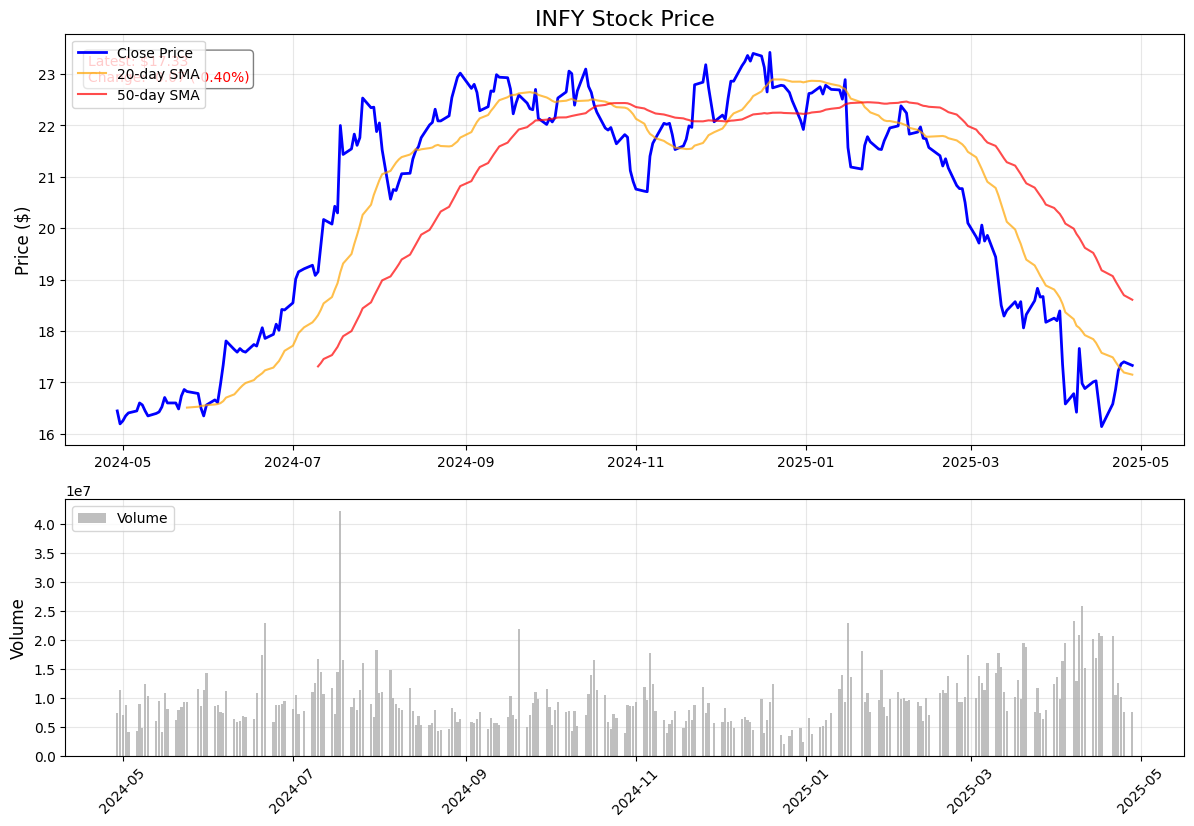


Price Changes:
1w: ▲ 2.79%
1m: ▼ 4.62%
3m: ▼ 19.51%
6m: ▼ 20.51%

RSI: 55.79 (Neutral)
MACD Signal: Bullish
Volatility (annualized): 25.69%


In [29]:
# Get Infosys (INFY) stock data for the past year
ticker = "INFY"
infy_data = stock_agent.get_stock_data(ticker, period="1y")

if not infy_data.empty:
    # Calculate technical indicators
    infy_data_with_indicators = stock_agent.calculate_technical_indicators(infy_data)
    
    # Plot stock data
    fig = stock_agent.plot_stock_data(infy_data_with_indicators, ticker)
    plt.show()
    
    # Get price movement analysis
    price_analysis = stock_agent.analyze_price_movement(infy_data_with_indicators, ticker)
    
    # Display price changes over different periods
    print("\nPrice Changes:")
    for period, values in price_analysis["returns"].items():
        direction = "▲" if values['pct_change'] > 0 else "▼"
        print(f"{period}: {direction} {abs(values['pct_change']):.2f}%")
        
    # Display technical indicators
    if 'rsi' in price_analysis:
        print(f"\nRSI: {price_analysis['rsi']['value']:.2f} ({price_analysis['rsi']['signal']})")
        
    if 'macd' in price_analysis:
        print(f"MACD Signal: {price_analysis['macd']['signal']}")
        
    if 'volatility' in price_analysis:
        print(f"Volatility (annualized): {price_analysis['volatility']['annualized'] * 100:.2f}%")
else:
    print(f"No data available for {ticker}. Make sure you have a valid internet connection and the ticker symbol is correct.")

In [30]:
# Get LLM analysis for Infosys stock
ticker = "INFY"
llm_analysis = stock_agent.analyze_with_llm(ticker)

print("\nLLM Analysis of Infosys (INFY) Stock:")
print("-" * 80)
print(llm_analysis)
print("-" * 80)

Generating price analysis for INFY...
Using cached data for INFY

LLM Analysis of Infosys (INFY) Stock:
--------------------------------------------------------------------------------
<think>
Okay, so I need to analyze the performance of Infosys Limited's stock based on the data provided. Let me go through each part step by step.

First, the summary of recent stock performance. The current price is $17.33 as of 2025-04-28. Looking at the past month, it went down by 4.62%. That's a loss in value over the last 30 days. Three months back, it was down by 19.51%, which is even more significant—a nearly 20% drop. Six months ago, the stock also fell by 20.51%. So overall, the company has been in a downward trend recently.

Next up are the technical indicators. The RSI is at 55.79, which is considered neutral. Typically, RSI values below 30 indicate overbought conditions, while above 70 suggest oversold. Since it's right around the middle, there might not be a strong buying or selling signal 

### Creating an Interactive Stock Analysis Widget

In [31]:
def create_stock_analysis_widget():
    """Create an interactive widget for stock price analysis"""
    # Create widgets
    ticker_input = widgets.Text(
        value='INFY',
        description='Ticker:',
        placeholder='Enter ticker symbol',
        layout=widgets.Layout(width='50%')
    )
    
    period_dropdown = widgets.Dropdown(
        options=[('1 Month', '1mo'), ('3 Months', '3mo'), ('6 Months', '6mo'), 
                ('1 Year', '1y'), ('2 Years', '2y'), ('5 Years', '5y')],
        value='1y',
        description='Period:',
        layout=widgets.Layout(width='40%')
    )
    
    output = widgets.Output()
    
    # Create tabs for different analyses
    tab_titles = ['Chart', 'Analysis', 'Company Info']
    tab = widgets.Tab()
    tab_contents = [widgets.Output() for _ in range(len(tab_titles))]
    tab.children = tab_contents
    
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Submit button
    button = widgets.Button(
        description='Analyze Stock',
        button_style='primary',
        tooltip='Click to analyze stock',
        icon='chart-line'
    )
    
    def on_button_clicked(_):
        # Clear all tab outputs
        for output in tab_contents:
            output.clear_output()
        
        ticker = ticker_input.value.strip().upper()
        period = period_dropdown.value
        
        if not ticker:
            with output:
                print("Please enter a ticker symbol.")
            return
        
        with output:
            print(f"Analyzing {ticker} for {period_dropdown.label}...")
        
        # Get stock data
        stock_data = stock_agent.get_stock_data(ticker, period=period)
        
        if stock_data.empty:
            with output:
                print(f"No data found for {ticker}. Please check if the ticker symbol is correct.")
            return
        
        # Calculate technical indicators
        stock_data_with_indicators = stock_agent.calculate_technical_indicators(stock_data)
        
        # Tab 1: Chart
        with tab_contents[0]:
            fig = stock_agent.plot_stock_data(stock_data_with_indicators, ticker)
            plt.show()
        
        # Tab 2: Analysis
        with tab_contents[1]:
            display(Markdown("## Technical Analysis"))
            
            # Show price changes
            price_analysis = stock_agent.analyze_price_movement(stock_data_with_indicators, ticker)
            display(Markdown("### Price Changes"))
            
            # Create a Pandas DataFrame to display price changes nicely
            changes_data = []
            for period, values in price_analysis["returns"].items():
                direction = "▲" if values['pct_change'] > 0 else "▼"
                changes_data.append({
                    "Period": period,
                    "Change": f"{direction} {abs(values['pct_change']):.2f}%"
                })
            
            if changes_data:
                display(pd.DataFrame(changes_data))
            
            # Display technical indicators
            display(Markdown("### Technical Indicators"))
            indicators_data = {}
            
            if 'rsi' in price_analysis:
                indicators_data["RSI"] = f"{price_analysis['rsi']['value']:.2f} ({price_analysis['rsi']['signal']})"
                
            if 'macd' in price_analysis:
                indicators_data["MACD Signal"] = price_analysis['macd']['signal']
                
            if 'volatility' in price_analysis:
                indicators_data["Volatility (annual)"] = f"{price_analysis['volatility']['annualized'] * 100:.2f}%"
                
            if indicators_data:
                display(pd.DataFrame(indicators_data.items(), columns=["Indicator", "Value"]))
                
            # LLM Analysis
            display(Markdown("### AI Analysis"))
            print("Generating AI analysis...")
            llm_analysis = stock_agent.analyze_with_llm(ticker, period)
            display(Markdown(llm_analysis))
        
        # Tab 3: Company Info
        with tab_contents[2]:
            display(Markdown("## Company Information"))
            company_info = stock_agent.get_company_info(ticker)
            
            if "error" in company_info:
                display(Markdown(f"Error: {company_info['error']}"))
            else:
                # Format market cap
                if company_info.get("market_cap", "N/A") != "N/A":
                    market_cap = company_info["market_cap"]
                    if market_cap > 1e9:
                        company_info["market_cap"] = f"${market_cap/1e9:.2f} billion"
                    else:
                        company_info["market_cap"] = f"${market_cap/1e6:.2f} million"
                
                # Format dividend yield
                if company_info.get("dividend_yield", "N/A") != "N/A":
                    company_info["dividend_yield"] = f"{company_info['dividend_yield'] * 100:.2f}%"
                
                # Display company info
                display(Markdown(f"### {company_info.get('name', ticker)}"))
                display(Markdown(f"**Sector:** {company_info.get('sector', 'N/A')}"))
                display(Markdown(f"**Industry:** {company_info.get('industry', 'N/A')}"))
                display(Markdown(f"**Market Cap:** {company_info.get('market_cap', 'N/A')}"))
                
                # Create a DataFrame for key statistics
                stats = {
                    "P/E Ratio": company_info.get("pe_ratio", "N/A"),
                    "EPS": company_info.get("eps", "N/A"),
                    "Dividend Yield": company_info.get("dividend_yield", "N/A"),
                    "52-Week High": company_info.get("52week_high", "N/A"),
                    "52-Week Low": company_info.get("52week_low", "N/A"),
                    "Avg. Volume": company_info.get("avg_volume", "N/A")
                }
                
                display(Markdown("### Key Statistics"))
                display(pd.DataFrame(stats.items(), columns=["Metric", "Value"]))
                
                # Display company description
                if company_info.get("description", "") != "N/A":
                    display(Markdown("### Business Description"))
                    display(Markdown(company_info.get("description", "")))
        
        with output:
            print(f"Analysis of {ticker} complete. View the tabs above for results.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Stock Price Analysis</h3>"),
        widgets.HBox([ticker_input, period_dropdown]),
        button,
        output,
        tab
    ])

In [32]:
# Create and display the stock analysis widget
stock_widget = create_stock_analysis_widget()
display(stock_widget)

## 9. Integrated Financial Analysis System

Now we'll create a comprehensive financial analysis system that integrates:
1. Document analysis from our RAG system
2. News analysis from our News Agent
3. Stock price analysis from our Stock Price Agent

In [33]:
def integrated_financial_analysis(company_name: str, ticker: str, query: str, vector_store):
    """
    Perform comprehensive financial analysis using all three agents
    
    Args:
        company_name: Full name of the company (e.g., 'Infosys')
        ticker: Stock ticker symbol (e.g., 'INFY')
        query: User's question about the company
        vector_store: FAISS vector store for document analysis
        
    Returns:
        Integrated analysis combining documents, news, and stock data
    """
    print(f"Starting comprehensive analysis for {company_name} ({ticker})...\n")
    
    # Step 1: Get document analysis from RAG
    print("Retrieving information from financial documents...")
    rag_answer, docs = answer_question(query, vector_store)
    document_sources = set([doc.metadata.get("source", "Unknown") for doc in docs])
    print(f"Retrieved context from {len(document_sources)} documents\n")
    
    # Step 2: Get news analysis
    print("Analyzing recent news...")
    try:
        if news_agent.api_key:
            news_result = news_agent.summarize_news(company_name)
            news_analysis = news_result.get("analysis", "No news analysis available.")
            news_articles = news_result.get("articles", [])
        else:
            # Use sample data if no API key
            analysis_result = news_agent.analyze_sentiment(sample_news)
            news_analysis = analysis_result.get("analysis", "No news analysis available.")
            news_articles = sample_news
            print("Using sample news data (set an API key for real-time news)")
    except Exception as e:
        print(f"Error getting news: {e}")
        news_analysis = "Error retrieving news analysis."
        news_articles = []
    print(f"Analyzed {len(news_articles)} news articles\n")
    
    # Step 3: Get stock price analysis
    print("Analyzing stock price data...")
    try:
        stock_data = stock_agent.get_stock_data(ticker, period="1y")
        
        if stock_data.empty:
            stock_analysis = f"No stock data available for {ticker}"
            price_data = {}
        else:
            # Calculate technical indicators
            stock_data_with_indicators = stock_agent.calculate_technical_indicators(stock_data)
            
            # Get price analysis
            price_data = stock_agent.analyze_price_movement(stock_data_with_indicators, ticker)
            
            # Get LLM analysis
            stock_analysis = stock_agent.analyze_with_llm(ticker)
    except Exception as e:
        print(f"Error analyzing stock data: {e}")
        stock_analysis = f"Error analyzing stock price data: {str(e)}"
        price_data = {}
    print("Stock analysis completed\n")
    
    # Step 4: Combine all analyses using LLM
    print("Generating integrated analysis...")
    
    # Prepare price changes summary for prompt
    price_summary = ""
    if price_data and "returns" in price_data:
        price_summary = "Recent price changes:\n"
        for period, values in price_data.get("returns", {}).items():
            direction = "up" if values['pct_change'] > 0 else "down"
            price_summary += f"- {period}: {direction} {abs(values['pct_change']):.2f}%\n"
            
    # Create integrated prompt
    prompt = f"""
    I need a comprehensive financial analysis of {company_name} ({ticker}) that answers this question: "{query}"
    
    Please integrate the following sources of information:
    
    1. HISTORICAL DOCUMENT ANALYSIS:
    {rag_answer}
    
    2. RECENT NEWS ANALYSIS:
    {news_analysis}
    
    3. STOCK PRICE ANALYSIS:
    {price_summary}
    {stock_analysis}
    
    Please provide a well-structured, comprehensive answer that:
    1. Directly answers the question: "{query}"
    2. Integrates insights from financial documents, recent news, and stock performance
    3. Highlights any contradictions or confirmations between different sources
    4. Provides context about both historical performance and recent developments
    5. Summarizes key takeaways at the end
    
    Format your response as a professional financial analysis report with appropriate sections and headers.
    Make your analysis balanced, factual, and evidence-based.
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        integrated_analysis = response['message']['content']
    except Exception as e:
        print(f"Error generating integrated analysis: {e}")
        integrated_analysis = "Error generating integrated analysis. Please see individual analyses above."
    
    return {
        "company": company_name,
        "ticker": ticker,
        "query": query,
        "integrated_analysis": integrated_analysis,
        "document_analysis": rag_answer,
        "document_sources": list(document_sources),
        "news_analysis": news_analysis,
        "news_sources": [a.get("title", "") for a in news_articles[:3]],
        "stock_analysis": stock_analysis,
        "price_data": price_data
    }

In [ ]:
def create_master_analysis_widget(vector_store):
    """Create a comprehensive financial intelligence widget"""
    # Create widgets
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Company name',
        layout=widgets.Layout(width='50%')
    )
    
    ticker_input = widgets.Text(
        value='INFY',
        description='Ticker:',
        placeholder='Stock ticker symbol',
        layout=widgets.Layout(width='30%')
    )
    
    question_input = widgets.Text(
        value='What are the company\'s growth prospects and main risks?',
        description='Question:',
        placeholder='Enter your financial analysis question',
        layout=widgets.Layout(width='80%')
    )
    
    include_sentiment = widgets.Checkbox(
        value=True,
        description='Include sentiment analysis',
        disabled=sentiment_agent is None
    )
    
    document_dropdown = widgets.Dropdown(
        options=[(filename, i) for i, (filename, _) in enumerate(documents)],
        description='Document:',
        layout=widgets.Layout(width='60%')
    )
    
    output = widgets.Output()
    
    # Create tabs for different analyses
    tab_titles = ['Financial Intelligence Report', 'Document Analysis', 'Sentiment Analysis', 'News Analysis', 'Stock Analysis']
    tab = widgets.Tab()
    tab_contents = [widgets.Output() for _ in range(len(tab_titles))]
    tab.children = tab_contents
    
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Submit button
    button = widgets.Button(
        description='Generate Financial Intelligence',
        button_style='danger',  # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Generate comprehensive financial intelligence report',
        icon='finance-chart'
    )
    
    def on_button_clicked(_):
        # Clear outputs
        output.clear_output()
        for tab_output in tab_contents:
            tab_output.clear_output()
            
        company = company_input.value.strip()
        ticker = ticker_input.value.strip().upper()
        question = question_input.value.strip()
        doc_index = document_dropdown.value if include_sentiment.value else -1
        
        if not company or not ticker or not question:
            with output:
                print("Please fill in all fields: Company name, Ticker symbol, and Question.")
            return
        
        with output:
            print(f"Analyzing {company} ({ticker}) - Question: {question}")
            print("This comprehensive analysis may take several minutes to complete...")
        
        # Run integrated analysis
        try:
            result = integrated_financial_intelligence(
                company, ticker, question, vector_store,
                include_sentiment=include_sentiment.value,
                document_index=doc_index
            )
            
            # Tab 1: Financial Intelligence Report
            with tab_contents[0]:
                display(Markdown(f"# Financial Intelligence Report: {company} ({ticker})"))
                display(Markdown(f"**Question:** {question}"))
                display(Markdown("---"))
                display(Markdown(result["integrated_analysis"]))
            
            # Tab 2: Document Analysis
            with tab_contents[1]:
                display(Markdown("# Document Analysis"))
                display(Markdown(result["document_analysis"]))
                display(Markdown("\n### Document Sources"))
                for source in result["document_sources"]:
                    display(Markdown(f"- {source}"))
            
            # Tab 3: Sentiment Analysis
            with tab_contents[2]:
                display(Markdown("# Sentiment Analysis"))
                display(Markdown(result["sentiment_summary"]))
                
                # Show visualization if sentiment data is available
                if result["sentiment_result"]:
                    sentiment_agent.visualize_sentiment(result["sentiment_result"])
                    
                    # Get top negative chunks
                    display(Markdown("\n### Top Negative Content"))
                    top_negative = sentiment_agent.get_top_chunks(result["sentiment_result"], "negative", 3)
                    for i, chunk in enumerate(top_negative, 1):
                        display(Markdown(f"**{i}. Negative Score: {chunk['probabilities']['negative']:.2f}**"))
                        display(Markdown(f"_{chunk['text']}_\n"))
            
            # Tab 4: News Analysis
            with tab_contents[3]:
                display(Markdown("# News Analysis"))
                display(Markdown(result["news_analysis"]))
                if result["news_sources"]:
                    display(Markdown("\n### Recent Headlines"))
                    for source in result["news_sources"]:
                        display(Markdown(f"- {source}"))
            
            # Tab 5: Stock Analysis
            with tab_contents[4]:
                display(Markdown("# Stock Price Analysis"))
                display(Markdown(result["stock_analysis"]))
                
                # Display price chart if we have data
                if result["price_data"] and not isinstance(result["price_data"], str):
                    if "error" not in result["price_data"]:
                        # Get fresh data for visualization
                        stock_data = stock_agent.get_stock_data(ticker, period="1y")
                        if not stock_data.empty:
                            stock_data_with_indicators = stock_agent.calculate_technical_indicators(stock_data)
                            fig = stock_agent.plot_stock_data(stock_data_with_indicators, ticker)
                            plt.show()
            
            with output:
                print("Financial Intelligence analysis complete! View the Financial Intelligence Report tab for the integrated analysis.")
                
        except Exception as e:
            with output:
                print(f"Error during analysis: {str(e)}")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h2>Financial Intelligence System</h2>"),
        widgets.HTML("<p>Comprehensive analysis integrating documents, sentiment, news, and stock data</p>"),
        widgets.HBox([company_input, ticker_input]),
        question_input,
        widgets.HBox([include_sentiment, document_dropdown]),
        button,
        output,
        tab
    ])

In [ ]:
# Create and display the master analysis widget
master_widget = create_master_analysis_widget(vector_store)
display(master_widget)

## 10. Sentiment Analysis Agent - Financial Text Analysis

Now let's implement a Sentiment Analysis Agent that can evaluate the sentiment in financial documents.
This agent will:

1. Analyze sentiment in financial reports using FinBERT
2. Track sentiment changes across different reports and time periods
3. Identify positive, negative, and neutral sections of documents
4. Integrate sentiment insights with our existing analysis system

In [36]:
# Install required packages for Sentiment Analysis Agent
# %pip install torch transformers pdfplumber nltk matplotlib pandas

In [37]:
# Import necessary libraries for sentiment analysis
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from typing import List, Dict, Optional, Tuple, Union
from nltk.tokenize import sent_tokenize
import nltk
import textwrap
import re


# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

class SentimentAnalysisAgent:
    """Agent for analyzing sentiment in financial documents using FinBERT."""
    
    def __init__(self, model_name: str = "yiyanghkust/finbert-tone", max_length: int = 512):
        """Initialize the Sentiment Analysis Agent with a FinBERT model."""
        self.model_name = model_name
        self.max_length = max_length
        print(f"Loading FinBERT model: {model_name}...")
        self.tokenizer, self.model = self._load_finbert()
        print("Sentiment Analysis Agent initialized successfully!")
    
    def _load_finbert(self) -> Tuple[BertTokenizer, BertForSequenceClassification]:
        """Load the FinBERT model and tokenizer."""
        try:
            tokenizer = BertTokenizer.from_pretrained(self.model_name)
            model = BertForSequenceClassification.from_pretrained(self.model_name)
            return tokenizer, model
        except Exception as e:
            print(f"Failed to load FinBERT: {e}")
            raise
    
    def _preprocess_text(self, text: str) -> List[str]:
        """Split text into chunks using sentence-aware token-based logic."""
        # Clean text first
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Split into sentences
        sentences = sent_tokenize(text)
        chunks, current_chunk = [], []

        # Create chunks based on max token length
        for sentence in sentences:
            tokens = self.tokenizer.encode(' '.join(current_chunk + [sentence]), add_special_tokens=False)
            if len(tokens) <= self.max_length - 2:  # -2 for [CLS] and [SEP] tokens
                current_chunk.append(sentence)
            else:
                chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]

        if current_chunk:
            chunks.append(' '.join(current_chunk))

        return chunks
    
    def _analyze_sentiment(self, chunks: List[str]) -> List[Dict]:
        """Run sentiment analysis on text chunks."""
        self.model.eval()
        sentiment_results = []
        label_map = {0: "negative", 1: "neutral", 2: "positive"}
        
        print(f"Analyzing sentiment for {len(chunks)} chunks...")
        
        with torch.no_grad():
            for i, chunk in enumerate(chunks):
                if i % 10 == 0 and i > 0:
                    print(f"Processed {i}/{len(chunks)} chunks")
                    
                inputs = self.tokenizer(chunk, return_tensors="pt", truncation=True, 
                                       padding=True, max_length=self.max_length)
                outputs = self.model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).tolist()[0]

                pred_label_idx = torch.argmax(logits, dim=1).item()
                pred_label = label_map[pred_label_idx]
                confidence = probs[pred_label_idx]

                sentiment_results.append({
                    "text": chunk,
                    "sentiment": pred_label,
                    "confidence": confidence,
                    "probabilities": dict(zip(["negative", "neutral", "positive"], probs))
                })

        return sentiment_results
    
    def _aggregate_sentiment(self, sentiment_results: List[Dict]) -> Dict:
        """Aggregate sentiment across chunks."""
        avg_probs = {"negative": 0, "neutral": 0, "positive": 0}
        n_chunks = len(sentiment_results)
        
        if n_chunks == 0:
            return {
                "overall_sentiment": "neutral",
                "overall_confidence": 0,
                "average_probabilities": avg_probs,
                "detailed_results": []
            }

        for result in sentiment_results:
            for label, prob in result["probabilities"].items():
                avg_probs[label] += prob / n_chunks

        overall_sentiment = max(avg_probs, key=avg_probs.get)
        overall_confidence = avg_probs[overall_sentiment]

        # Calculate counts
        sentiment_counts = {"positive": 0, "neutral": 0, "negative": 0}
        for result in sentiment_results:
            sentiment_counts[result["sentiment"]] += 1
            
        sentiment_percentages = {
            k: (v / n_chunks) * 100 for k, v in sentiment_counts.items()
        }

        return {
            "overall_sentiment": overall_sentiment,
            "overall_confidence": overall_confidence,
            "average_probabilities": avg_probs,
            "sentiment_counts": sentiment_counts,
            "sentiment_percentages": sentiment_percentages,
            "detailed_results": sentiment_results,
            "total_chunks": n_chunks
        }
    
    def analyze_document(self, document_text: str, document_name: str = "Unknown") -> Dict:
        """Process a document and return sentiment analysis results."""
        print(f"Analyzing sentiment for document: {document_name}")
        
        # Preprocess and chunk the text
        chunks = self._preprocess_text(document_text)
        print(f"Split document into {len(chunks)} chunks for analysis")
        
        # Run sentiment analysis
        sentiment_results = self._analyze_sentiment(chunks)
        
        # Aggregate results
        aggregated_result = self._aggregate_sentiment(sentiment_results)
        
        print(f"Overall sentiment: {aggregated_result['overall_sentiment']} "
              f"(Confidence: {aggregated_result['overall_confidence']:.2f})")
        
        return {
            "document_name": document_name,
            "result": aggregated_result
        }
    
    def analyze_multiple_documents(self, documents: List[Tuple[str, str]]) -> Dict:
        """Analyze sentiment across multiple documents."""
        results = []
        combined_chunks = []
        
        for doc_text, doc_name in documents:
            result = self.analyze_document(doc_text, doc_name)
            results.append(result)
            
            # Collect all chunks for combined analysis
            combined_chunks.extend(result["result"]["detailed_results"])
        
        # Perform combined analysis
        overall_result = self._aggregate_sentiment(combined_chunks)
        
        return {
            "individual_results": results,
            "overall_result": overall_result
        }
    
    def visualize_sentiment(self, result: Dict):
        """Visualize sentiment analysis results."""
        if "sentiment_counts" in result:
            # For aggregated results
            counts = result["sentiment_counts"]
        else:
            # For individual document results
            counts = result["result"]["sentiment_counts"]
            
        labels = list(counts.keys())
        values = list(counts.values())
        colors = ["red", "gray", "green"]
        
        # Create pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
        plt.title("Sentiment Distribution")
        plt.axis('equal')  # Equal aspect ratio ensures pie is circular
        plt.show()
        
        # Create bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.bar(labels, values, color=colors)
        plt.title("Sentiment Distribution")
        plt.xlabel("Sentiment")
        plt.ylabel("Number of Chunks")
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f"{height:.0f}",
                    ha='center', va='bottom')
        plt.show()
    
    def get_top_chunks(self, result: Dict, sentiment_type: str = "negative", top_n: int = 5) -> List[Dict]:
        """Get top chunks with highest probability of specified sentiment."""
        if "detailed_results" in result:
            # For aggregated results
            chunks = result["detailed_results"]
        else:
            # For individual document results
            chunks = result["result"]["detailed_results"]
            
        # Sort by the specified sentiment probability
        sorted_chunks = sorted(chunks, key=lambda x: x["probabilities"][sentiment_type], reverse=True)
        
        return sorted_chunks[:top_n]
    
    def summarize_with_llm(self, result: Dict, query: str = None, llm_model: str = "deepseek-r1") -> str:
        """Generate a summary of the sentiment analysis using an LLM"""
        # Extract sentiment information
        if "overall_sentiment" in result:
            # For aggregated results
            overall_sentiment = result["overall_sentiment"]
            confidence = result["overall_confidence"]
            percentages = result["sentiment_percentages"]
            document_name = "the documents"
        else:
            # For individual document results
            overall_sentiment = result["result"]["overall_sentiment"]
            confidence = result["result"]["overall_confidence"]
            percentages = result["result"]["sentiment_percentages"]
            document_name = result["document_name"]
        
        # Get top positive and negative chunks
        top_positive = self.get_top_chunks(result, "positive", 3)
        top_negative = self.get_top_chunks(result, "negative", 3)
        
        # Prepare positive and negative examples
        positive_examples = "\n".join([
            f"- {textwrap.shorten(chunk['text'], width=100, placeholder='...')}" 
            for chunk in top_positive
        ])
        
        negative_examples = "\n".join([
            f"- {textwrap.shorten(chunk['text'], width=100, placeholder='...')}" 
            for chunk in top_negative
        ])
        
        # Prepare prompt for LLM
        if query:
            prompt_intro = f"Please analyze the sentiment in {document_name} to answer this question: '{query}'"
        else:
            prompt_intro = f"Please provide a summary of the sentiment analysis for {document_name}."
        
        prompt = f"""
        {prompt_intro}
        
        Sentiment Analysis Results:
        - Overall sentiment: {overall_sentiment.capitalize()} (Confidence: {confidence:.2f})
        - Distribution:
          - Positive: {percentages['positive']:.1f}%
          - Neutral: {percentages['neutral']:.1f}%
          - Negative: {percentages['negative']:.1f}%
        
        Examples of most positive content:
        {positive_examples}
        
        Examples of most negative content:
        {negative_examples}
        
        Please provide:
        1. A brief summary of the overall sentiment in the document(s)
        2. Your interpretation of what these sentiment patterns might indicate
        3. How the key positive and negative themes might impact financial performance or outlook
        
        Structure your answer in a clear, concise manner with headers for each section. Focus on financial implications.
        """
        
        try:
            response = ollama.chat(
                model=llm_model,
                messages=[{"role": "user", "content": prompt}]
            )
            return response['message']['content']
        except Exception as e:
            print(f"Error generating LLM summary: {e}")
            return f"Error generating sentiment summary: {str(e)}"

# Initialize the Sentiment Analysis Agent
try:
    sentiment_agent = SentimentAnalysisAgent()
except Exception as e:
    print(f"Error initializing Sentiment Analysis Agent: {e}")
    print("Will attempt to initialize when first used.")
    sentiment_agent = None

[nltk_data] Downloading package punkt_tab to /home/dhruv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/dhruv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dhruv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/dhruv/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading FinBERT model: yiyanghkust/finbert-tone...
Sentiment Analysis Agent initialized successfully!


### Testing Sentiment Analysis on Documents

Let's test the Sentiment Analysis Agent on one of our financial reports:


Testing sentiment analysis on a sample from: infosys-ar-20.pdf
Sample length: 20000 characters
Analyzing sentiment for document: infosys-ar-20.pdf
Split document into 8 chunks for analysis
Analyzing sentiment for 8 chunks...
Split document into 8 chunks for analysis
Analyzing sentiment for 8 chunks...
Overall sentiment: neutral (Confidence: 0.78)
Overall sentiment: neutral (Confidence: 0.78)


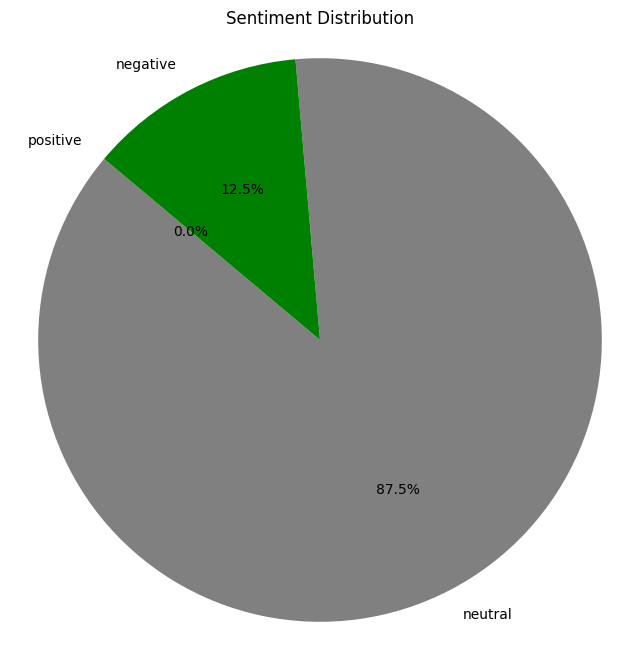

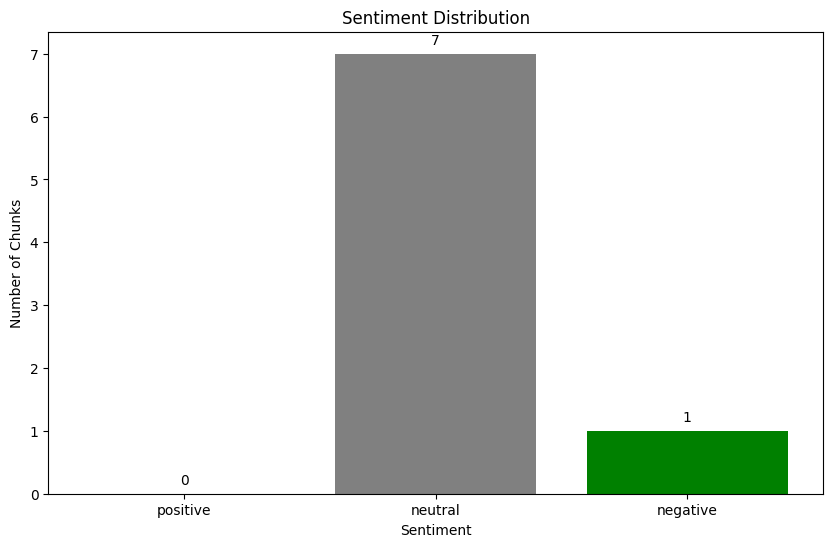


Top negative chunks:
1. Negative score: 0.98
” – Viren Shah, Chief Digital Officer, GE Appliances Infosys Annual Report...

2. Negative score: 0.37
In an entirely different department and context, delivery project managers,...

3. Negative score: 0.23
This is a combination of evolutionary, historic and real-time information...


Generating LLM summary of sentiment...

Sentiment Summary:
--------------------------------------------------------------------------------
<think>
Okay, so I need to provide a summary based on the sentiment analysis of an Infosys document. The user has already given me some data: overall sentiment is neutral with 78% confidence, positive is 0%, neutral is 87.5%, and negative is 12.5%. They also provided examples of positive and negative content.

First, I should understand what each part means. The overall sentiment being neutral suggests that the document isn't leaning towards positive or negative emotions on average. But it's not entirely neutral because th

In [38]:
# If sentiment_agent failed to initialize earlier, try again
if sentiment_agent is None:
    try:
        sentiment_agent = SentimentAnalysisAgent()
    except Exception as e:
        print(f"Error initializing Sentiment Analysis Agent: {e}")
        print("Skipping sentiment analysis test")

if sentiment_agent is not None and documents:
    # Take the first document for testing
    test_doc_name, test_doc_text = documents[0]
    
    # Only use the first part of the document to speed up testing
    test_sample = test_doc_text[:20000]  # First ~20k characters
    
    print(f"\nTesting sentiment analysis on a sample from: {test_doc_name}")
    print(f"Sample length: {len(test_sample)} characters")
    
    # Run sentiment analysis
    sample_result = sentiment_agent.analyze_document(test_sample, test_doc_name)
    
    # Show sentiment distribution
    sentiment_agent.visualize_sentiment(sample_result)
    
    # Show top negative chunks
    top_negative_chunks = sentiment_agent.get_top_chunks(sample_result, "negative", 3)
    print("\nTop negative chunks:")
    for i, chunk in enumerate(top_negative_chunks, 1):
        print(f"{i}. Negative score: {chunk['probabilities']['negative']:.2f}")
        print(textwrap.shorten(chunk['text'], width=80, placeholder="..."))
        print()
    
    # Get LLM summary
    print("\nGenerating LLM summary of sentiment...")
    llm_summary = sentiment_agent.summarize_with_llm(sample_result)
    print("\nSentiment Summary:")
    print("-" * 80)
    print(llm_summary)
    print("-" * 80)

### Creating a Sentiment Analysis Widget

Let's create an interactive widget for analyzing sentiment in documents:

In [39]:
def create_sentiment_analysis_widget():
    """Create an interactive widget for sentiment analysis of documents"""
    # Initialize sentiment agent if needed
    global sentiment_agent
    if sentiment_agent is None:
        try:
            sentiment_agent = SentimentAnalysisAgent()
        except Exception as e:
            return widgets.HTML(f"<h3>Error: Could not initialize Sentiment Analysis Agent</h3><p>{str(e)}</p>")
    
    # Create widgets
    document_dropdown = widgets.Dropdown(
        options=[(filename, i) for i, (filename, _) in enumerate(documents)],
        description='Document:',
        layout=widgets.Layout(width='60%')
    )
    
    sample_checkbox = widgets.Checkbox(
        value=True,
        description='Use sample only (faster)',
        disabled=False
    )
    
    sample_size_slider = widgets.IntSlider(
        value=20000,
        min=5000,
        max=50000,
        step=5000,
        description='Sample size:',
        disabled=False,
        layout=widgets.Layout(width='50%')
    )
    
    query_input = widgets.Text(
        value='What is the general sentiment and what are the main concerns?',
        placeholder='Enter question for sentiment analysis',
        description='Query:',
        layout=widgets.Layout(width='80%')
    )
    
    output = widgets.Output()
    
    # Create tabs for different analyses
    tab_titles = ['Summary', 'Visualization', 'Top Chunks']
    tab = widgets.Tab()
    tab_contents = [widgets.Output() for _ in range(len(tab_titles))]
    tab.children = tab_contents
    
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Submit button
    button = widgets.Button(
        description='Analyze Sentiment',
        button_style='info',
        tooltip='Click to analyze sentiment',
        icon='chart-bar'
    )
    
    def on_button_clicked(_):
        # Clear outputs
        output.clear_output()
        for tab_output in tab_contents:
            tab_output.clear_output()
            
        # Get selected document
        doc_index = document_dropdown.value
        doc_name, doc_text = documents[doc_index]
        
        with output:
            print(f"Analyzing sentiment for: {doc_name}")
            
            # Use sample or full document
            if sample_checkbox.value:
                sample_size = sample_size_slider.value
                doc_text = doc_text[:sample_size]
                print(f"Using first {sample_size} characters (sample mode)")
            else:
                print(f"Using full document ({len(doc_text)} characters)")
                
            print("Running sentiment analysis... (this may take a minute)")
        
        try:
            # Run sentiment analysis
            result = sentiment_agent.analyze_document(doc_text, doc_name)
            
            # Get LLM summary
            query = query_input.value if query_input.value.strip() else None
            llm_summary = sentiment_agent.summarize_with_llm(result, query)
            
            # Tab 1: Summary
            with tab_contents[0]:
                display(Markdown("## Sentiment Analysis Summary"))
                display(Markdown(llm_summary))
                
                # Show overall stats
                display(Markdown("\n### Overall Statistics"))
                display(Markdown(f"**Overall Sentiment:** {result['result']['overall_sentiment'].capitalize()} "
                               f"(Confidence: {result['result']['overall_confidence']:.2f})"))
                
                # Create a DataFrame for percentages
                sentiments = pd.DataFrame([
                    {"Sentiment": k.capitalize(), "Percentage": f"{v:.1f}%", "Raw": v}
                    for k, v in result['result']['sentiment_percentages'].items()
                ])
                sentiments = sentiments.sort_values('Raw', ascending=False).drop('Raw', axis=1)
                display(sentiments)
            
            # Tab 2: Visualization
            with tab_contents[1]:
                display(Markdown("## Sentiment Distribution"))
                sentiment_agent.visualize_sentiment(result)
            
            # Tab 3: Top Chunks
            with tab_contents[2]:
                display(Markdown("## Top Positive Chunks"))
                top_positive = sentiment_agent.get_top_chunks(result, "positive", 5)
                for i, chunk in enumerate(top_positive, 1):
                    display(Markdown(f"**{i}. Positive Score: {chunk['probabilities']['positive']:.2f}**"))
                    display(Markdown(f"_{textwrap.shorten(chunk['text'], width=120, placeholder='...')}_\n"))
                
                display(Markdown("## Top Negative Chunks"))
                top_negative = sentiment_agent.get_top_chunks(result, "negative", 5)
                for i, chunk in enumerate(top_negative, 1):
                    display(Markdown(f"**{i}. Negative Score: {chunk['probabilities']['negative']:.2f}**"))
                    display(Markdown(f"_{textwrap.shorten(chunk['text'], width=120, placeholder='...')}_\n"))
            
            with output:
                print("Sentiment analysis complete! View results in the tabs above.")
                
        except Exception as e:
            with output:
                print(f"Error analyzing sentiment: {str(e)}")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>Financial Document Sentiment Analysis</h3>"),
        widgets.HBox([document_dropdown]),
        widgets.HBox([sample_checkbox, sample_size_slider]),
        query_input,
        button,
        output,
        tab
    ])

In [40]:
# Create and display the sentiment analysis widget
sentiment_widget = create_sentiment_analysis_widget()
display(sentiment_widget)

## 11. Complete Financial Intelligence System

Now let's integrate all our agents into a comprehensive Financial Intelligence System that combines:
1. Document analysis from our RAG system
2. Sentiment analysis from our Sentiment Analysis Agent
3. News analysis from our News Agent
4. Stock price analysis from our Stock Price Agent

In [41]:
def integrated_financial_intelligence(company_name: str, ticker: str, query: str, vector_store,
                                     include_sentiment: bool = True, document_index: int = 0):
    """Comprehensive financial analysis using all four agents"""
    print(f"Starting comprehensive financial intelligence analysis for {company_name} ({ticker})...\n")
    
    # Step 1: Get document analysis from RAG
    print("Retrieving information from financial documents...")
    rag_answer, docs = answer_question(query, vector_store)
    document_sources = set([doc.metadata.get("source", "Unknown") for doc in docs])
    print(f"Retrieved context from {len(document_sources)} documents\n")
    
    # Step 2: Get sentiment analysis
    if include_sentiment and sentiment_agent is not None and document_index < len(documents):
        print("Analyzing sentiment in financial documents...")
        doc_name, doc_text = documents[document_index]
        try:
            # Use sample of document for faster processing
            doc_sample = doc_text[:30000]  # First ~30k characters
            sentiment_result = sentiment_agent.analyze_document(doc_sample, doc_name)
            sentiment_summary = sentiment_agent.summarize_with_llm(
                sentiment_result, 
                f"How does the sentiment in this document relate to {query}"
            )
            print(f"Sentiment analysis completed for {doc_name}\n")
        except Exception as e:
            print(f"Error in sentiment analysis: {e}")
            sentiment_summary = "Error performing sentiment analysis."
            sentiment_result = None
    else:
        sentiment_summary = "Sentiment analysis not included in this analysis."
        sentiment_result = None
        print("Skipping sentiment analysis...\n")
    
    # Step 3: Get news analysis
    print("Analyzing recent news...")
    try:
        if news_agent.api_key:
            news_result = news_agent.summarize_news(company_name)
            news_analysis = news_result.get("analysis", "No news analysis available.")
            news_articles = news_result.get("articles", [])
        else:
            # Use sample data if no API key
            analysis_result = news_agent.analyze_sentiment(sample_news)
            news_analysis = analysis_result.get("analysis", "No news analysis available.")
            news_articles = sample_news
            print("Using sample news data (set an API key for real-time news)")
    except Exception as e:
        print(f"Error getting news: {e}")
        news_analysis = "Error retrieving news analysis."
        news_articles = []
    print(f"Analyzed {len(news_articles)} news articles\n")
    
    # Step 4: Get stock price analysis
    print("Analyzing stock price data...")
    try:
        stock_data = stock_agent.get_stock_data(ticker, period="1y")
        
        if stock_data.empty:
            stock_analysis = f"No stock data available for {ticker}"
            price_data = {}
        else:
            # Calculate technical indicators
            stock_data_with_indicators = stock_agent.calculate_technical_indicators(stock_data)
            
            # Get price analysis
            price_data = stock_agent.analyze_price_movement(stock_data_with_indicators, ticker)
            
            # Get LLM analysis
            stock_analysis = stock_agent.analyze_with_llm(ticker)
    except Exception as e:
        print(f"Error analyzing stock data: {e}")
        stock_analysis = f"Error analyzing stock price data: {str(e)}"
        price_data = {}
    print("Stock analysis completed\n")
    
    # Step 5: Combine all analyses using LLM
    print("Generating integrated financial intelligence analysis...")
    
    # Prepare price changes summary for prompt
    price_summary = ""
    if price_data and "returns" in price_data:
        price_summary = "Recent price changes:\n"
        for period, values in price_data.get("returns", {}).items():
            direction = "up" if values['pct_change'] > 0 else "down"
            price_summary += f"- {period}: {direction} {abs(values['pct_change']):.2f}%\n"
    
    # Add sentiment information if available
    sentiment_info = ""
    if sentiment_result:
        sentiment_data = sentiment_result["result"]
        sentiment_info = f"""
        Overall sentiment: {sentiment_data['overall_sentiment']}
        Positive content: {sentiment_data['sentiment_percentages']['positive']:.1f}%
        Neutral content: {sentiment_data['sentiment_percentages']['neutral']:.1f}%
        Negative content: {sentiment_data['sentiment_percentages']['negative']:.1f}%
        """
            
    # Create integrated prompt
    prompt = f"""
    I need a comprehensive financial intelligence analysis of {company_name} ({ticker}) that answers this question: "{query}"
    
    Please integrate the following sources of information:
    
    1. HISTORICAL DOCUMENT ANALYSIS:
    {rag_answer}
    
    2. DOCUMENT SENTIMENT ANALYSIS:
    {sentiment_info}
    {sentiment_summary}
    
    3. RECENT NEWS ANALYSIS:
    {news_analysis}
    
    4. STOCK PRICE ANALYSIS:
    {price_summary}
    {stock_analysis}
    
    Please provide an in-depth, financial analysis report that:
    1. Directly answers the question: "{query}"
    2. Integrates insights from all four data sources (documents, sentiment, news, and stock performance)
    3. Highlights correlations between sentiment in documents, news developments, and stock price movements
    4. Identifies potential risks and opportunities based on the combined analysis
    5. Provides a structured executive summary with clear sections and key takeaways
    
    Format your response as a professional financial analysis report with appropriate sections and headers.
    Make your analysis balanced, factual, and evidence-based.
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        integrated_analysis = response['message']['content']
    except Exception as e:
        print(f"Error generating integrated analysis: {e}")
        integrated_analysis = "Error generating integrated financial intelligence analysis. Please see individual analyses above."
    
    print("Analysis complete!")
    
    return {
        "company": company_name,
        "ticker": ticker,
        "query": query,
        "integrated_analysis": integrated_analysis,
        "document_analysis": rag_answer,
        "document_sources": list(document_sources),
        "sentiment_summary": sentiment_summary,
        "sentiment_result": sentiment_result,
        "news_analysis": news_analysis,
        "news_sources": [a.get("title", "") for a in news_articles[:3]],
        "stock_analysis": stock_analysis,
        "price_data": price_data
    }

In [42]:
def create_master_analysis_widget(vector_store):
    """Create a comprehensive financial intelligence widget"""
    # Create widgets
    company_input = widgets.Text(
        value='Infosys',
        description='Company:',
        placeholder='Company name',
        layout=widgets.Layout(width='50%')
    )
    
    ticker_input = widgets.Text(
        value='INFY',
        description='Ticker:',
        placeholder='Stock ticker symbol',
        layout=widgets.Layout(width='30%')
    )
    
    question_input = widgets.Text(
        value='What are the company\'s growth prospects and main risks?',
        description='Question:',
        placeholder='Enter your financial analysis question',
        layout=widgets.Layout(width='80%')
    )
    
    include_sentiment = widgets.Checkbox(
        value=True,
        description='Include sentiment analysis',
        disabled=sentiment_agent is None
    )
    
    document_dropdown = widgets.Dropdown(
        options=[(filename, i) for i, (filename, _) in enumerate(documents)],
        description='Document:',
        layout=widgets.Layout(width='60%')
    )
    
    output = widgets.Output()
    
    # Create tabs for different analyses
    tab_titles = ['Financial Intelligence Report', 'Document Analysis', 'Sentiment Analysis', 'News Analysis', 'Stock Analysis']
    tab = widgets.Tab()
    tab_contents = [widgets.Output() for _ in range(len(tab_titles))]
    tab.children = tab_contents
    
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Submit button
    button = widgets.Button(
        description='Generate Financial Intelligence',
        button_style='danger',  # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Generate comprehensive financial intelligence report',
        icon='finance-chart'
    )
    
    def on_button_clicked(_):
        # Clear outputs
        output.clear_output()
        for tab_output in tab_contents:
            tab_output.clear_output()
            
        company = company_input.value.strip()
        ticker = ticker_input.value.strip().upper()
        question = question_input.value.strip()
        doc_index = document_dropdown.value if include_sentiment.value else -1
        
        if not company or not ticker or not question:
            with output:
                print("Please fill in all fields: Company name, Ticker symbol, and Question.")
            return
        
        with output:
            print(f"Analyzing {company} ({ticker}) - Question: {question}")
            print("This comprehensive analysis may take several minutes to complete...")
        
        # Run integrated analysis
        try:
            result = integrated_financial_intelligence(
                company, ticker, question, vector_store,
                include_sentiment=include_sentiment.value,
                document_index=doc_index
            )
            
            # Tab 1: Financial Intelligence Report
            with tab_contents[0]:
                display(Markdown(f"# Financial Intelligence Report: {company} ({ticker})"))
                display(Markdown(f"**Question:** {question}"))
                display(Markdown("---"))
                display(Markdown(result["integrated_analysis"]))
            
            # Tab 2: Document Analysis
            with tab_contents[1]:
                display(Markdown("# Document Analysis"))
                display(Markdown(result["document_analysis"]))
                display(Markdown("\n### Document Sources"))
                for source in result["document_sources"]:
                    display(Markdown(f"- {source}"))
            
            # Tab 3: Sentiment Analysis
            with tab_contents[2]:
                display(Markdown("# Sentiment Analysis"))
                display(Markdown(result["sentiment_summary"]))
                
                # Show visualization if sentiment data is available
                if result["sentiment_result"]:
                    sentiment_agent.visualize_sentiment(result["sentiment_result"])
                    
                    # Get top negative chunks
                    display(Markdown("\n### Top Negative Content"))
                    top_negative = sentiment_agent.get_top_chunks(result["sentiment_result"], "negative", 3)
                    for i, chunk in enumerate(top_negative, 1):
                        display(Markdown(f"**{i}. Negative Score: {chunk['probabilities']['negative']:.2f}**"))
                        display(Markdown(f"_{chunk['text']}_\n"))
            
            # Tab 4: News Analysis
            with tab_contents[3]:
                display(Markdown("# News Analysis"))
                display(Markdown(result["news_analysis"]))
                if result["news_sources"]:
                    display(Markdown("\n### Recent Headlines"))
                    for source in result["news_sources"]:
                        display(Markdown(f"- {source}"))
            
            # Tab 5: Stock Analysis
            with tab_contents[4]:
                display(Markdown("# Stock Price Analysis"))
                display(Markdown(result["stock_analysis"]))
                
                # Display price chart if we have data
                if result["price_data"] and not isinstance(result["price_data"], str):
                    if "error" not in result["price_data"]:
                        # Get fresh data for visualization
                        stock_data = stock_agent.get_stock_data(ticker, period="1y")
                        if not stock_data.empty:
                            stock_data_with_indicators = stock_agent.calculate_technical_indicators(stock_data)
                            fig = stock_agent.plot_stock_data(stock_data_with_indicators, ticker)
                            plt.show()
            
            with output:
                print("Financial Intelligence analysis complete! View the Financial Intelligence Report tab for the integrated analysis.")
                
        except Exception as e:
            with output:
                print(f"Error during analysis: {str(e)}")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h2>Financial Intelligence System</h2>"),
        widgets.HTML("<p>Comprehensive analysis integrating documents, sentiment, news, and stock data</p>"),
        widgets.HBox([company_input, ticker_input]),
        question_input,
        widgets.HBox([include_sentiment, document_dropdown]),
        button,
        output,
        tab
    ])

In [43]:
# Create and display the master analysis widget
master_widget = create_master_analysis_widget(vector_store)
display(master_widget)

## 12. Custom Report Analysis and Comparison

Now let's analyze the custom report "MIDAS Technology Sector Infosys.pdf" and compare its insights with the annual reports analysis.

In [45]:
# First, let's load the custom report
custom_report_path = "../../MIDAS Technology Sector Infosys.pdf"


print(f"Loading custom report: {custom_report_path}")
custom_report_text = load_pdf(custom_report_path)
custom_documents = [("MIDAS Technology Sector Infosys.pdf", custom_report_text)]
print(f"Successfully loaded the custom report with {len(custom_report_text)} characters")



Loading custom report: ../../MIDAS Technology Sector Infosys.pdf
Processing 19 pages...
Processed 5/19 pages
Processed 10/19 pages
Processed 10/19 pages
Processed 15/19 pages
Processed 19/19 pages
Extracted 23361 characters of text.
Successfully loaded the custom report with 23361 characters
Processed 15/19 pages
Processed 19/19 pages
Extracted 23361 characters of text.
Successfully loaded the custom report with 23361 characters


In [46]:
# Create vector store for the custom report
if custom_documents:
    custom_vector_store, custom_chunks = create_vector_store(custom_documents)
    print(f"Created vector store for custom report with {len(custom_chunks)} chunks")
else:
    print("Skipping vector store creation for custom report as it was not found.")

Split text into 34 chunks across 1 documents (took 0.00 seconds)
Initializing embedding model...
Creating vector store...
Vector store created with 34 vectors (took 0.04 seconds)
Created vector store for custom report with 34 chunks
Creating vector store...
Vector store created with 34 vectors (took 0.04 seconds)
Created vector store for custom report with 34 chunks


In [47]:
def compare_analyses(query, original_vector_store, custom_vector_store):
    print(f"Comparing analyses for query: {query}")
    
    # Get answer from original reports
    print("\nAnalyzing original annual reports...")
    original_answer, original_docs = answer_question(query, original_vector_store)
    
    # Get answer from custom report
    print("\nAnalyzing custom MIDAS report...")
    custom_answer, custom_docs = answer_question(query, custom_vector_store)
    
    # Calculate similarity score using LLM
    prompt = f"""
    I need to compare two analyses of the same question about Infosys to calculate 
    a similarity score from 0 to 100.
    
    Question: {query}
    
    Analysis from annual reports:
    {original_answer}
    
    Analysis from custom MIDAS report:
    {custom_answer}
    
    Please calculate:
    1. A similarity score from 0-100 indicating how closely these analyses align
    2. Key areas where the analyses agree
    3. Key differences between the analyses
    4. Which analysis provides more detailed or comprehensive information
    
    Present your response in a structured format with clear headings and explanations.
    Begin with a number for the similarity score, then your detailed explanation.
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        comparison = response['message']['content']
    except Exception as e:
        print(f"Error generating comparison: {e}")
        comparison = f"Error comparing analyses. Original and custom analyses are provided separately."
    
    return {
        "query": query,
        "original_analysis": original_answer,
        "custom_analysis": custom_answer,
        "comparison": comparison,
        "original_sources": [doc.metadata.get("source", "Unknown") for doc in original_docs[:3]],
        "custom_sources": [doc.metadata.get("source", "Unknown") for doc in custom_docs[:3]]
    }

In [48]:
if 'custom_vector_store' in locals():
    # Define key questions for comparison
    comparison_questions = [
        "What are Infosys' key financial highlights?",
        "What is Infosys' growth strategy?",
        "What are the main risks and challenges facing Infosys?",
        "How is Infosys performing in digital transformation?",
        "What are Infosys' ESG initiatives and sustainability efforts?"
    ]
    
    # Create a tab for each question
    tab_titles = [f"Q{i+1}: {q[:20]}..." for i, q in enumerate(comparison_questions)]
    comparison_tab = widgets.Tab()
    comparison_contents = [widgets.Output() for _ in range(len(comparison_questions))]
    comparison_tab.children = comparison_contents
    
    for i, title in enumerate(tab_titles):
        comparison_tab.set_title(i, title)
    
    # Run comparisons
    comparison_results = []
    for i, question in enumerate(comparison_questions):
        result = compare_analyses(question, vector_store, custom_vector_store)
        comparison_results.append(result)
        
        # Display in appropriate tab
        with comparison_contents[i]:
            display(Markdown(f"# Comparison Analysis: {question}"))
            display(Markdown("## Similarity Assessment"))
            display(Markdown(result["comparison"]))
            
            display(Markdown("## Annual Reports Analysis"))
            display(Markdown(result["original_analysis"]))
            display(Markdown("\n**Sources:**"))
            for source in result["original_sources"]:
                display(Markdown(f"- {source}"))
            
            display(Markdown("## Custom MIDAS Report Analysis"))
            display(Markdown(result["custom_analysis"]))
            display(Markdown("\n**Sources:**"))
            for source in result["custom_sources"]:
                display(Markdown(f"- {source}"))
    
    # Display the comparison tabs
    display(widgets.HTML("<h2>Comparison of Annual Reports vs. MIDAS Report Analysis</h2>"))
    display(comparison_tab)
else:
    print("Cannot run comparison as the custom report vector store was not created.")

Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What is Infosys' growth strategy?

Analyzing original annual reports...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3381 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2958 characters (took 5.79 seconds)
Generated answer of 2958 characters (took 5.79 seconds)


Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What is Infosys' growth strategy?

Analyzing original annual reports...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3381 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2958 characters (took 5.79 seconds)
Generated answer of 2958 characters (took 5.79 seconds)


Comparing analyses for query: What are the main risks and challenges facing Infosys?

Analyzing original annual reports...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3970 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4536 characters (took 9.54 seconds)
Generated answer of 4536 characters (took

Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What is Infosys' growth strategy?

Analyzing original annual reports...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3381 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2958 characters (took 5.79 seconds)
Generated answer of 2958 characters (took 5.79 seconds)


Comparing analyses for query: What are the main risks and challenges facing Infosys?

Analyzing original annual reports...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3970 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4536 characters (took 9.54 seconds)
Generated answer of 4536 characters (took

Comparing analyses for query: How is Infosys performing in digital transformation?

Analyzing original annual reports...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3778 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 3894 characters (took 8.32 seconds)
Generated answer of 3894 characters (took 8.32 se

Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What is Infosys' growth strategy?

Analyzing original annual reports...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3381 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2958 characters (took 5.79 seconds)
Generated answer of 2958 characters (took 5.79 seconds)


Comparing analyses for query: What are the main risks and challenges facing Infosys?

Analyzing original annual reports...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3970 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4536 characters (took 9.54 seconds)
Generated answer of 4536 characters (took

Comparing analyses for query: How is Infosys performing in digital transformation?

Analyzing original annual reports...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3778 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 3894 characters (took 8.32 seconds)
Generated answer of 3894 characters (took 8.32 se

Comparing analyses for query: What are Infosys' ESG initiatives and sustainability efforts?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3982 characters to Ollama...
Generated answer of 3895 characters (took 8.67 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3304 characters to Ollama...
Generated answer of 3895 characters (took 8.67 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3304 characters to Ollama...
Generated answer of 2746 characters (took 5.61 seconds)
Generated ans

Comparing analyses for query: What are Infosys' key financial highlights?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3469 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3264 characters (took 9.48 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' key financial highlights?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4079 characters to Ollama...
Generated answer of 3254 characters (took 7.95 seconds)
Generated answer of 3254 characters (took 7.95 seconds)


Comparing analyses for query: What is Infosys' growth strategy?

Analyzing original annual reports...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3381 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2976 characters (took 5.74 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What is Infosys' growth strategy?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 2933 characters to Ollama...
Generated answer of 2958 characters (took 5.79 seconds)
Generated answer of 2958 characters (took 5.79 seconds)


Comparing analyses for query: What are the main risks and challenges facing Infosys?

Analyzing original annual reports...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3970 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4139 characters (took 7.96 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are the main risks and challenges facing Infosys?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4011 characters to Ollama...
Generated answer of 4536 characters (took 9.54 seconds)
Generated answer of 4536 characters (took

Comparing analyses for query: How is Infosys performing in digital transformation?

Analyzing original annual reports...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3778 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 2533 characters (took 5.05 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'How is Infosys performing in digital transformation?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 4080 characters to Ollama...
Generated answer of 3894 characters (took 8.32 seconds)
Generated answer of 3894 characters (took 8.32 se

Comparing analyses for query: What are Infosys' ESG initiatives and sustainability efforts?

Analyzing original annual reports...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3982 characters to Ollama...
Generated answer of 3895 characters (took 8.67 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3304 characters to Ollama...
Generated answer of 3895 characters (took 8.67 seconds)

Analyzing custom MIDAS report...
Searching for context relevant to: 'What are Infosys' ESG initiatives and sustainability efforts?'
Retrieved 4 relevant chunks (took 0.01 seconds)
Sending prompt with context of 3304 characters to Ollama...
Generated answer of 2746 characters (took 5.61 seconds)
Generated ans

HTML(value='<h2>Comparison of Annual Reports vs. MIDAS Report Analysis</h2>')

## 13. Future Enhancements

This notebook can be enhanced further by:
- Adding more sophisticated error handling and logging
- Integrating additional data sources for real-time analysis
- Enhancing the user interface for better usability
- Providing more detailed documentation and user guidance
- Implementing feedback mechanisms to improve the models over time

### Summary and Conclusion

In this notebook, we've built a complete Retrieval-Augmented Generation (RAG) system that:

1. Loads and processes PDF documents
2. Chunks text and creates vector embeddings
3. Performs similarity search to find relevant context
4. Uses Ollama with the deepseek-r1 model to generate answers
5. Provides an interactive interface for querying the document

This implementation demonstrates the core components of a RAG system, but there are many ways to improve it further, as outlined in the improvements section.

Key takeaways:
- RAG enhances LLM responses with relevant context from specific documents
- The quality of chunking and embeddings directly impacts retrieval performance
- Local models like those in Ollama provide privacy and control advantages
- Error handling is crucial for production-ready RAG systems

# ---